##Fund Analysis to Predict Top Performing Mutual Funds

**Topic Name : Mutual Fund Predictive Analytics**

By **Yashvi Vekariya ** (yashviivekariya@gmail.com)

In this notebook, I will read the fund data from CSV files which I created in earlier notebook **fund_web_Scraping.ipynb**  using Web scraping of [Morning Star](http://www.morningstar.com/) website.
Thereafter I will use data analysis and regression, Random Forest to predict Top performing funds which are good for investment.

I have collected past 10 years data of over 1000 funds. I will analyze the value of alpha, beta, return, R squared, sharpe ratio, standard deviation, expense ratio for each fund for 3 years, 5 years and 10 years and fit a model to predict top performing funds which are good for investment. I will also determine the relationship between Expense Ratio and Top performing funds.

Note : Please visit [Investopedia](http://www.investopedia.com/articles/mutualfund/112002.asp) website to know about Fiancial jargons e.g. alpha, Beta,etc. 


In [169]:
# Import Section
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 
import requests 
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import datetime as dt
from bs4 import BeautifulSoup
import urllib.request
from sklearn import linear_model
import scipy as sp
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
import bs4
import statsmodels.formula.api as smf
import html5lib
from matplotlib import rcParams
import math
import yfinance
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split

### Read Fund Meta data from CSV

Read fund meta data from csv file. This includes fund ticker, fund family and benchmark. I'll use fund ticker later to fetch returns and statistics for each fund from csv file.

In [170]:
# get fund meta data from CSV
fund_meta_data = pd.read_csv("../Fund_Data/Fund_Metadata.csv").drop(u'Unnamed: 0',axis =1)
fund_meta_data.head()

Fund_Name Fund_Family Fund_Ticker  \
0                  Vanguard 500 Index Inv    Vanguard       VFINX   
1             Vanguard Balanced Index Inv    Vanguard       VBINX   
2  Vanguard CA Interm-Term Tax-Exempt Inv    Vanguard       VCAIX   
3    Vanguard CA Long-Term Tax-Exempt Inv    Vanguard       VCITX   
4        Vanguard Capital Opportunity Inv    Vanguard       VHCOX   

                    Benchmark_Index  
0                    S&P 500 TR USD  
1  Morningstar Moderate Target Risk  
2         Barclays Municipal TR USD  
3         Barclays Municipal TR USD  
4                    S&P 500 TR USD

### Read Fund Returns and Statistics from CSV

Read fund returns and statistics from csv files using fund tickers.

In [171]:
fund_returns = {}

for ticker in fund_meta_data.Fund_Ticker:    # read returns for each fund
    fund_returns[ticker]=pd.read_csv("../Fund_Data/Fund_Returns/"+ticker+"_RETURNS.csv").drop(u'Unnamed: 0',axis =1).ffill().bfill()



In [172]:
#show returns from one fund
fund_returns['FBALX'].head()


Year  FBALX_Returns  Morningstar Moderate Target Risk  Category (LB)  \
0  1999           8.86                             13.49          10.71   
1  2000           5.32                              1.68           1.82   
2  2001           2.25                             -2.46          -5.05   
3  2002          -8.49                             -6.69         -12.02   
4  2003          28.24                             22.48          20.35   

   +/- S&P 500 TR USD  +/- Category (LB)  Annual_Net_Exp_Ratio  \
0               -4.64              -1.85                 -1.85   
1                3.64               3.50                  3.50   
2                4.71               7.30                  0.64   
3               -1.80               3.53                  0.66   
4                5.76               7.89                  0.67   

   Turnover_Ratio  Rank_In_Category  
0           -1.85              61.0  
1            3.50              27.0  
2          115.00               9.0  
3          150.00              20.0  
4          137.00               6.0

## 1. Determining Good Fund using Random Foreset Classifier

A good fund should give maximum returns with lesser risk i,e, it should be less volatile. A fund may be giving > 30 % returns based on its past performance but if it has a high volatility/high risk and Ind to loose more in case of loss.

Iused the information avaiable on  [Investopedia](http://www.investopedia.com/articles/mutualfund/112002.asp) to determine what should be the parameter values for a good fund.


### 1.1 Predict Good fund for 3 years of investments

In [173]:
# gather 3 year data for each fund
fund_data = pd.read_csv("../Fund_Data/Fund_Stats_Annualized_data/Fund_statistics_3years.csv").drop(u'Unnamed: 0',axis =1)
fund_data.head()

Fund_Ticker                   Benchmark_Index  R_Squared  Beta  Alpha  \
0       FRIFX                  MSCI ACWI NR USD      32.40  0.28   7.74   
1       VTWNX  Morningstar Moderate Target Risk      98.55  1.00   1.10   
2       JNBAX  Morningstar Moderate Target Risk      86.54  0.92   0.93   
3       FIOFX  Morningstar Moderate Target Risk      97.12  1.29  -0.77   
4       PTTRX       Barclays US Agg Bond TR USD      83.35  1.24   1.28   

   Treynor_Ratio Currency  Year_Trailing  Std_Dev  Return  Sharpe_Ratio  \
0          43.38      USD              3     5.25   12.39          2.25   
1          11.98      USD              3     6.41   12.01          1.80   
2          11.82      USD              3     6.30   10.92          1.67   
3          10.17      USD              3     8.35   13.18          1.52   
4           4.00      USD              3     3.68    5.03          1.34   

   Sortino_Ratio  
0           4.31  
1           3.29  
2           3.00  
3           2.60  
4           2.18

Expense ratio is the price paid by investor. It plays an imporant role while deciding fund's overall returns.
e.g. A fund is giving 11% returns with expense ratio of 1% is better than a fund giving 13% Returns with Expense ratio of 6%.

So I will calculate net returns as differnce between returns and the Expense Ratio.

In [174]:
fund_data['Expense_Ratio'] = [0.0]*len(fund_data)
i=0
for ticker in fund_data.Fund_Ticker:
    try:
        fund_data['Expense_Ratio'][i] = fund_returns[ticker]['Annual_Net_Exp_Ratio'][-3:].mean()
        
    except:
        fund_data['Expense_Ratio'][i] = np.nan

    i=i+1

fund_data['Expense_Ratio'] = fund_data['Expense_Ratio'].ffill()
fund_data['Net_returns'] = fund_data['Return'] - fund_data['Expense_Ratio']

fund_data.head()

/tmp/ipykernel_24038/3823172906.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  fund_data['Expense_Ratio'][i] = fund_returns[ticker]['Annual_Net_Exp_Ratio'][-3:].mean()
/tmp/ipykernel_24038/3823172906.py:5: SettingWithCopyWarning: 
A val

Fund_Ticker                   Benchmark_Index  R_Squared  Beta  Alpha  \
0       FRIFX                  MSCI ACWI NR USD      32.40  0.28   7.74   
1       VTWNX  Morningstar Moderate Target Risk      98.55  1.00   1.10   
2       JNBAX  Morningstar Moderate Target Risk      86.54  0.92   0.93   
3       FIOFX  Morningstar Moderate Target Risk      97.12  1.29  -0.77   
4       PTTRX       Barclays US Agg Bond TR USD      83.35  1.24   1.28   

   Treynor_Ratio Currency  Year_Trailing  Std_Dev  Return  Sharpe_Ratio  \
0          43.38      USD              3     5.25   12.39          2.25   
1          11.98      USD              3     6.41   12.01          1.80   
2          11.82      USD              3     6.30   10.92          1.67   
3          10.17      USD              3     8.35   13.18          1.52   
4           4.00      USD              3     3.68    5.03          1.34   

   Sortino_Ratio  Expense_Ratio  Net_returns  
0           4.31       0.853333    11.536667  
1           3.29       2.336667     9.673333  
2           3.00       0.600000    10.320000  
3           2.60       0.086667    13.093333  
4           2.18       0.460000     4.570000

From the information available fo [Investopedia website](http://www.investopedia.com/articles/mutualfund/112002.asp), a good fund should have the following values :

* R sqaured : between 85-100. 
* Return : as high as possible ( I consider return > 10 )
* Beta : greater than 1
* alpha : greater than 0
* sharpe ratio : greater than 0
* Standard deviation : low  ( I cosidered std deviation <15 )

Now I will create a function which assigns 1 or 0 based on the values of alpha, beta, return, R squared, sharpe ratio, standard deviation, expense ratio.

In [175]:
'''
convert quality to zero and 1
R_sqr = 85 and 100
beta = >1
alpha = >0
std < 9
Sharpe_Ratio>0
Net Returns>10
'''

def parse_returns(row):
    if((row.R_Squared >=85) & (row.R_Squared <=100) &
       (row.Beta > 1) &
       (row.Alpha >0) &
       (row.Std_Dev <15) &
       (row.Sharpe_Ratio  >0)&
       (row.Net_returns > 10)
       ):
        return 1
    else:
        return 0

Create a Y array  which gives 1 and 0 values for each fund based on parameters such as R squared value, alpha, beta, standard deviation, sharpe ratio, returns.

In [176]:
# fund data and decides 1 or 0.
def create_score(fund_data):    
    Y = [0.0]*len(fund_data)
    for i in range(len(fund_data)):
        Y[i] = parse_returns(fund_data.iloc[i])
    
    return Y

Y=create_score(fund_data)
#show some values of Y
Y[:15]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Create X and Y matrices from the avaibke data.
Consider X as the alpha, beta, sharpe ratio, returns, standard deviation, rsquared,etc parameters and Y as good_or_bad indicator which I calculated above.

In [177]:
# create X and Y data frame for analysis
X_df = fund_data.drop(fund_data.columns[[0,1,6,7,13]], axis=1)
X = X_df.values
Y = np.array(Y)

Use Random forest classifer and cross validation for number of trees ranging from 1 to 41 to find out which trees gives more accuracy. I will use f1 scoring parameter for cross validation

In [178]:
# Import the correct module
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# range of trees from 1 to 40
no_trees = range(1, 41)

# number of Folds = 10
k_fold = 10 

# Method 1: Store results in lists, then create DataFrame
num_trees_list = []
scores_list = []
mean_scores_list = []
std_scores_list = []

# compute score for various number of trees using RandomForestClassifier.
for i in no_trees:    
    forest = RandomForestClassifier(n_estimators=i, random_state=42)
    scores = cross_val_score(forest, X, Y, scoring='f1', cv=k_fold)
    
    num_trees_list.append(i)
    scores_list.append(scores.tolist())  # Convert to list for DataFrame storage
    mean_scores_list.append(scores.mean())
    std_scores_list.append(scores.std())

# Create DataFrame with results
df_random_forest = pd.DataFrame({
    'Num_Trees': num_trees_list,
    'Score': scores_list,
    'Mean_Score': mean_scores_list,
    'Std_Score': std_scores_list
})

# Display head of result
print(df_random_forest.head())

# Optional: Display summary statistics
print("\nSummary Statistics:")
print(f"Best mean F1 score: {df_random_forest['Mean_Score'].max():.4f}")
print(f"Best number of trees: {df_random_forest.loc[df_random_forest['Mean_Score'].idxmax(), 'Num_Trees']}")

"""
df_random_forest_alt = pd.DataFrame({
    'Num_Trees': [0] * len(no_trees),
    'Score': [None] * len(no_trees)  # Initialize with None
})

for i, n_trees in enumerate(no_trees):    
    forest = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    scores = cross_val_score(forest, X, Y, scoring='f1', cv=k_fold)
    
    df_random_forest_alt.at[i, 'Num_Trees'] = n_trees
    df_random_forest_alt.at[i, 'Score'] = scores  # Use .at for single value assignment
"""

   Num_Trees                                              Score  Mean_Score  \
0          1  [0.8571428571428571, 0.8571428571428571, 0.727...    0.817937   
1          2  [0.8571428571428571, 0.7692307692307693, 0.6, ...    0.826773   
2          3  [0.9333333333333333, 0.8571428571428571, 0.923...    0.878568   
3          4  [0.9333333333333333, 0.8571428571428571, 0.923...    0.875879   
4          5  [1.0, 0.9333333333333333, 0.9230769230769231, ...    0.890949   

   Std_Score  
0   0.090476  
1   0.101246  
2   0.062433  
3   0.083993  
4   0.091812  

Summary Statistics:
Best mean F1 score: 0.9388
Best number of trees: 21


"\ndf_random_forest_alt = pd.DataFrame({\n    'Num_Trees': [0] * len(no_trees),\n    'Score': [None] * len(no_trees)  # Initialize with None\n})\n\nfor i, n_trees in enumerate(no_trees):    \n    forest = RandomForestClassifier(n_estimators=n_trees, random_state=42)\n    scores = cross_val_score(forest, X, Y, scoring='f1', cv=k_fold)\n\n    df_random_forest_alt.at[i, 'Num_Trees'] = n_trees\n    df_random_forest_alt.at[i, 'Score'] = scores  # Use .at for single value assignment\n"

Now I will plot the data accuracy score of Random Forest against No. of Trees to find out which n_estimator gives better accuracy.

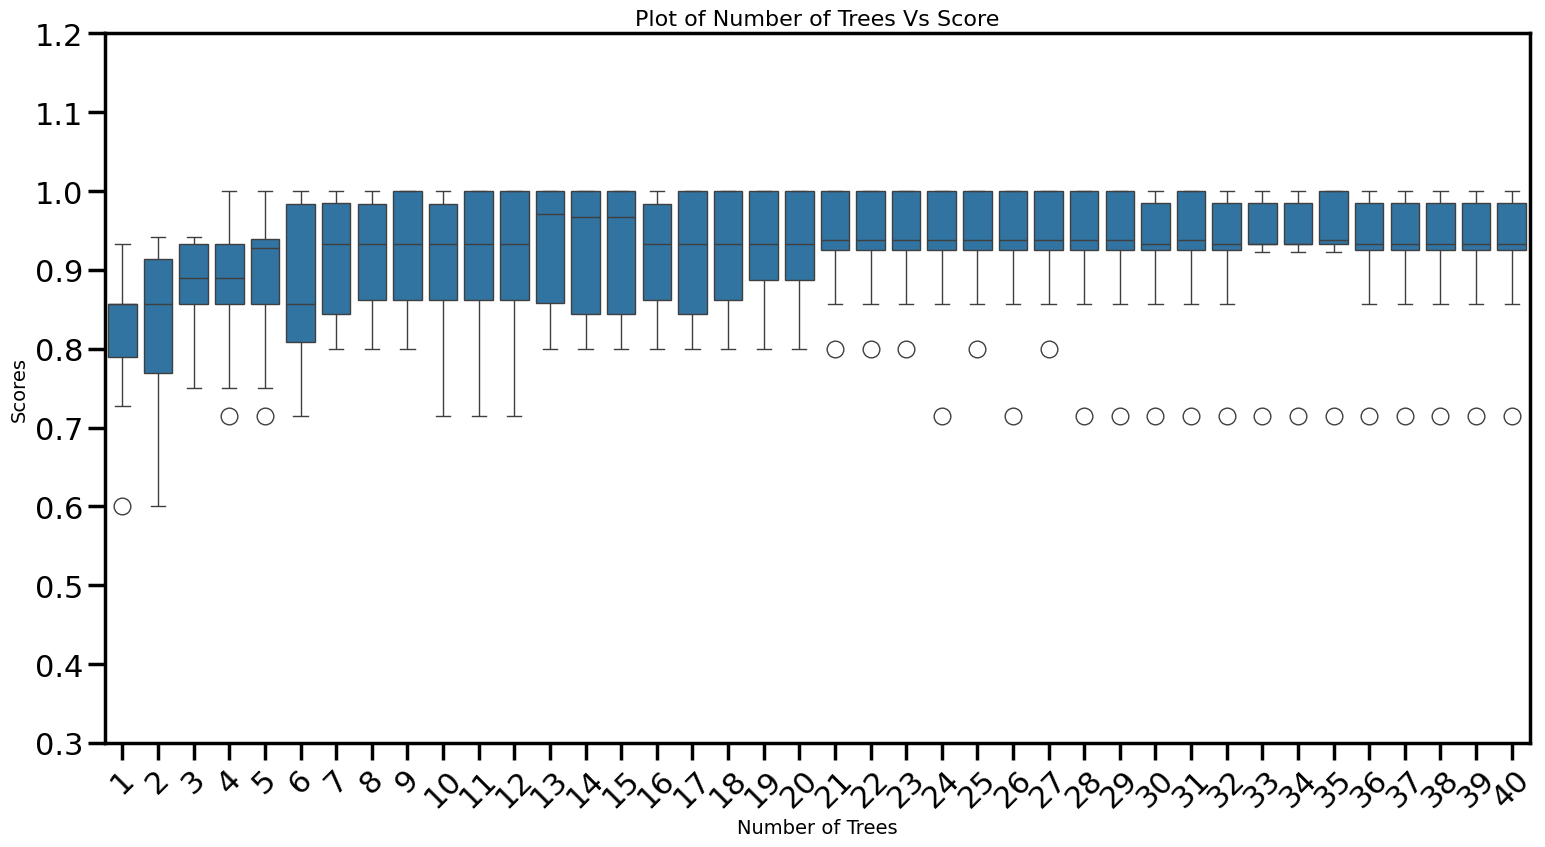

In [179]:
plot_data = []
for idx, row in df_random_forest.iterrows():
    for score in row['Score']:
        plot_data.append({
            'Num_Trees': row['Num_Trees'], 
            'Score': score
        })

plot_df = pd.DataFrame(plot_data)

# Create the boxplot
plt.figure(figsize=(16, 9))
sns.boxplot(data=plot_df, x='Num_Trees', y='Score')

plt.title("Plot of Number of Trees Vs Score", fontsize=16)
plt.xlabel("Number of Trees", fontsize=14)
plt.ylabel("Scores", fontsize=14)
plt.yticks(np.arange(0.3, 1.3, 0.1))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
sns.set_context('poster')
plt.show()

Based on the above graph I can say that n_estimator =25 gives the best accuracy. So I will Build a random forest model with n_estimator = 25 for further analysis.

I will also calculate feature importance.


In [180]:
## Train random forest classifier on the wine data using 13 trees. 
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=25)
clf = clf.fit(X,Y)

# obtain the relative importance of the features 
feature_imp = clf.feature_importances_

#get column names
columns = X_df.columns

print(feature_imp)

[0.15239349 0.20171829 0.18092977 0.11414952 0.07220823 0.1382685
 0.06882447 0.04797792 0.02352979]


Plot a graph of feature importance.

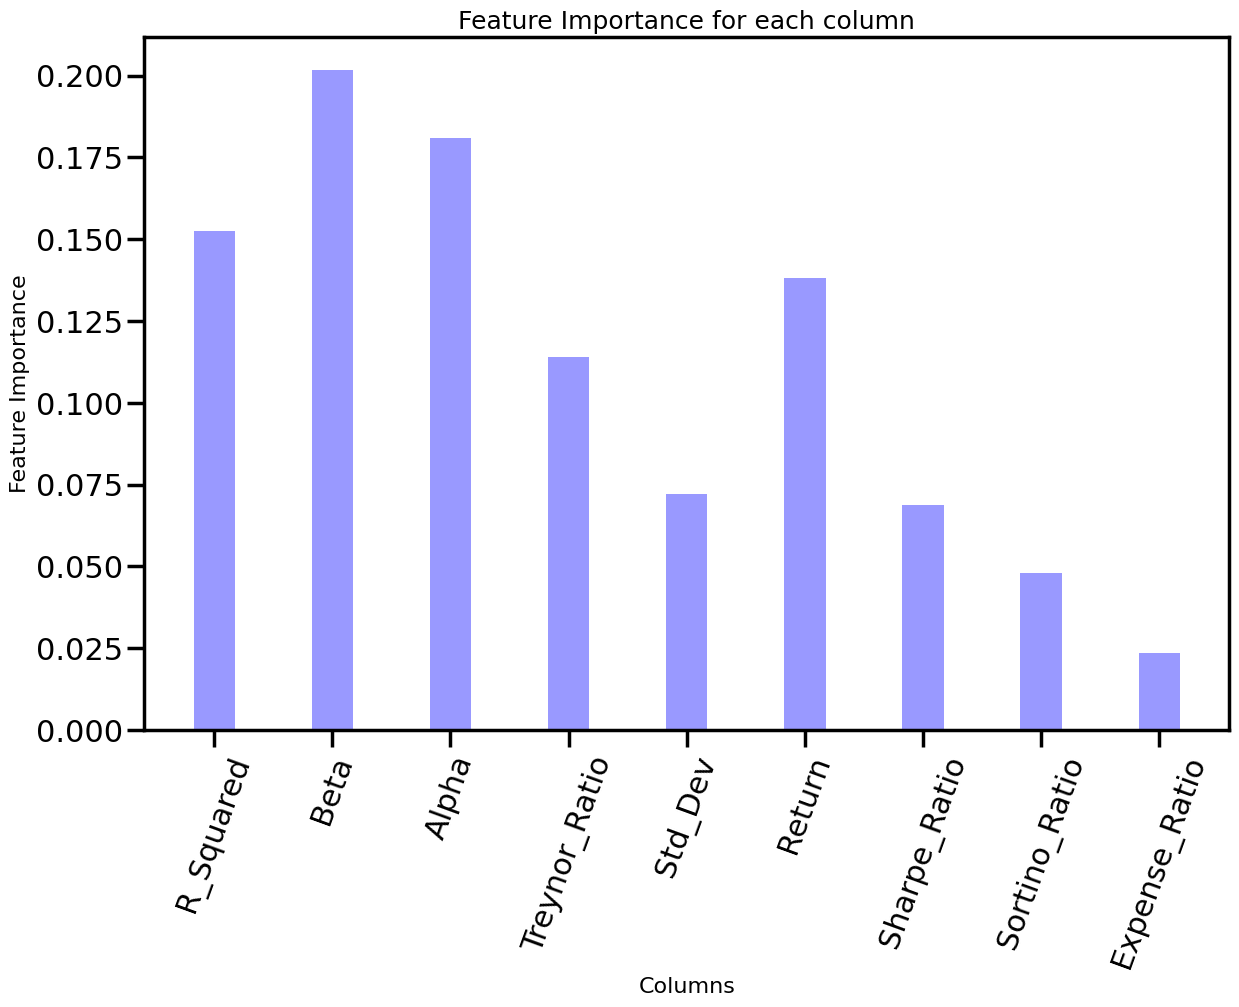

In [181]:
# Show a bar plot of feature imp of named features

index = np.arange(len(columns))
bar_width = 0.35
opacity = 0.4

plt.figure(figsize=(14,9))
plt.bar(index, feature_imp, bar_width,
                 alpha=opacity,
                 color='b',
                 label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column', fontsize =18)
plt.xticks(index, columns,rotation = 70)
plt.show()

Based on the above result I can say that Beta,R squared, Standard deviation and alpha,  are the important fearures when determining the good mutual fund.

Now predict good/bad funds based on random forest model fitted for X and Y. 

In [182]:
# Predict the result
Y_predict = clf.predict(X)
fund_data['Predicted_result'] = Y_predict
good_fund_three_yrs = (fund_data
                       .query("Predicted_result==1")
                       .sort_values('Net_returns', ascending=False)
                       .reset_index(drop=True))

# Display the results
print(f"Number of funds predicted as good performers: {len(good_fund_three_yrs)}")
print("\nTop 10 predicted good performing funds:")
print(good_fund_three_yrs.head(10))

Number of funds predicted as good performers: 79

Top 10 predicted good performing funds:
  Fund_Ticker Benchmark_Index  R_Squared  Beta  Alpha  Treynor_Ratio Currency  \
0       PSPTX  S&P 500 TR USD      92.11  1.05   2.54          23.83      USD   
1       PIXAX  S&P 500 TR USD      90.71  1.06   2.62          23.91      USD   
2       FSMVX  S&P 500 TR USD      87.41  1.10   1.13          22.18      USD   
3       FLCSX  S&P 500 TR USD      92.80  1.10   0.51          21.53      USD   
4       VFTSX  S&P 500 TR USD      95.11  1.06   0.70          21.72      USD   
5       PSTKX  S&P 500 TR USD      98.67  1.03   1.34          22.47      USD   
6       WOOPX  S&P 500 TR USD      88.74  1.12   0.04          21.01      USD   
7       VUVLX  S&P 500 TR USD      93.44  1.05   0.67          21.66      USD   
8       VSLPX  S&P 500 TR USD      98.73  1.04   0.42          21.39      USD   
9       JIISX  S&P 500 TR USD      96.07  1.06   0.60          21.61      USD   

   Year_Trailing  

Now Show Top performing 20 funds for investment.

In [183]:
good_fund_three_yrs[:20]

Fund_Ticker Benchmark_Index  R_Squared  Beta  Alpha  Treynor_Ratio  \
0        PSPTX  S&P 500 TR USD      92.11  1.05   2.54          23.83   
1        PIXAX  S&P 500 TR USD      90.71  1.06   2.62          23.91   
2        FSMVX  S&P 500 TR USD      87.41  1.10   1.13          22.18   
3        FLCSX  S&P 500 TR USD      92.80  1.10   0.51          21.53   
4        VFTSX  S&P 500 TR USD      95.11  1.06   0.70          21.72   
5        PSTKX  S&P 500 TR USD      98.67  1.03   1.34          22.47   
6        WOOPX  S&P 500 TR USD      88.74  1.12   0.04          21.01   
7        VUVLX  S&P 500 TR USD      93.44  1.05   0.67          21.66   
8        VSLPX  S&P 500 TR USD      98.73  1.04   0.42          21.39   
9        JIISX  S&P 500 TR USD      96.07  1.06   0.60          21.61   
10       JPIVX  S&P 500 TR USD      93.46  1.05   0.56          21.54   
11       TRVLX  S&P 500 TR USD      93.02  1.05   1.15          22.22   
12       JPIAX  S&P 500 TR USD      96.18  1.05   0.62          21.62   
13       JPIEX  S&P 500 TR USD      97.47  1.04   0.34          21.30   
14       FVDFX  S&P 500 TR USD      93.52  1.01   1.08          22.12   
15       SMGIX  S&P 500 TR USD      96.37  1.05   0.32          21.28   
16       VGRIX  S&P 500 TR USD      95.52  1.03   0.92          21.96   
17       JPGSX  S&P 500 TR USD      90.68  1.04   0.47          21.42   
18       FGRTX  S&P 500 TR USD      95.54  1.04   0.32          21.26   
19       VQNPX  S&P 500 TR USD      99.20  1.02   0.24          21.16   

   Currency  Year_Trailing  Std_Dev  Return  Sharpe_Ratio  Sortino_Ratio  \
0       USD              3     9.87   25.03          2.33           4.81   
1       USD              3    10.01   25.28          2.32           4.59   
2       USD              3    10.60   24.37          2.12           4.36   
3       USD              3    10.33   23.76          2.13           4.13   
4       USD              3     9.83   23.10          2.17           4.26   
5       USD              3     9.40   23.26          2.28           4.54   
6       USD              3    10.74   23.55          2.03           4.02   
7       USD              3     9.82   22.79          2.15           4.10   
8       USD              3     9.43   22.23          2.18           4.24   
9       USD              3     9.78   22.97          2.17           4.45   
10      USD              3     9.84   22.73          2.14           4.12   
11      USD              3     9.84   23.37          2.20           4.14   
12      USD              3     9.65   22.70          2.18           4.43   
13      USD              3     9.50   22.14          2.16           4.27   
14      USD              3     9.44   22.40          2.20           4.24   
15      USD              3     9.70   22.48          2.15           4.29   
16      USD              3     9.54   22.69          2.20           4.22   
17      USD              3     9.90   22.40          2.10           4.55   
18      USD              3     9.59   22.11          2.14           3.92   
19      USD              3     9.22   21.55          2.17           4.17   

    Expense_Ratio  Net_returns  Predicted_result  
0        0.640000    24.390000                 1  
1        1.190000    24.090000                 1  
2        0.720000    23.650000                 1  
3        0.913333    22.846667                 1  
4        0.280000    22.820000                 1  
5        0.500000    22.760000                 1  
6        0.960000    22.590000                 1  
7        0.290000    22.500000                 1  
8        0.170000    22.060000                 1  
9        0.970000    22.000000                 1  
10       0.793333    21.936667                 1  
11       1.500000    21.870000                 1  
12       0.926667    21.773333                 1  
13       0.450000    21.690000                 1  
14       0.800000    21.600000                 1  
15       0.886667    21.593333                 1  
16   

First I will see he relationship between expense ratio and Returns using scatter plot for top performing funds

In [184]:
good_fund_three_yrs.to_json("three_year_top_fund.json")

In [185]:
good_fund_three_yrs.columns

Index(['Fund_Ticker', 'Benchmark_Index', 'R_Squared', 'Beta', 'Alpha',
       'Treynor_Ratio', 'Currency', 'Year_Trailing', 'Std_Dev', 'Return',
       'Sharpe_Ratio', 'Sortino_Ratio', 'Expense_Ratio', 'Net_returns',
       'Predicted_result'],
      dtype='object')

Text(0, 0.5, 'Expense Ratio')

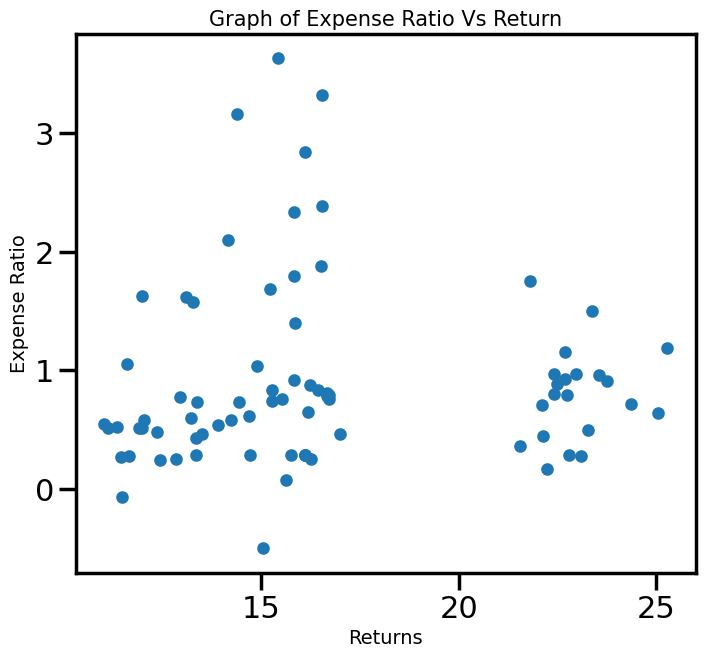

In [186]:
#Plot Returns  Vs Expense ratio
plt.figure(figsize=(8,7))
x=good_fund_three_yrs.Return
y=good_fund_three_yrs.Expense_Ratio
plt.scatter(x,y,s=50)
plt.title("Graph of Expense Ratio Vs Return", fontsize=15)
plt.xlabel("Returns" , fontsize=14)
plt.ylabel("Expense Ratio", fontsize=14)


From the above graph I can say that fund with higher  return usually have low expense ratio.

Now I will Plot a graph of Net Returns Vs Risk (Standard deviation) for good funds using scatter plot. 

In [187]:
'''
This function plots a graph of Returns Vs Standard deviation

'''
def plot_returns_Vs_risk(good_funds):
    x_arr= good_funds.Net_returns
    y_arr= good_funds.Std_Dev

    plt.figure(figsize=(12,10))

    plt.scatter(x_arr, y_arr)
    plt.xlabel('Net Returns ( Returns - Expense Ratio )')
    plt.ylabel('Risk')
    for label, x, y in zip(good_funds.Fund_Ticker, x_arr, y_arr):
        plt.annotate(
            label, 
            xy = (x, y), xytext = (20, -20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
        



Text(0.5, 1.0, 'Graph of Net Returns Vs Risk for 3 Years')

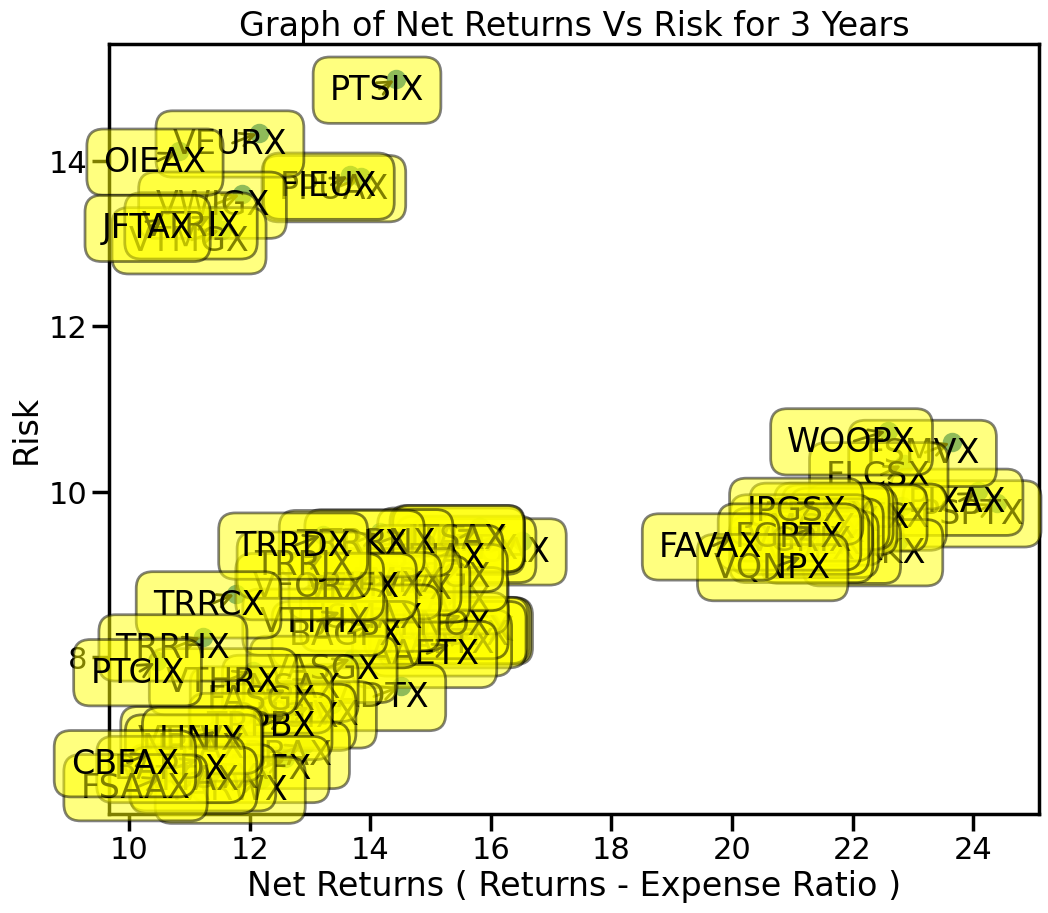

In [188]:
plot_returns_Vs_risk(good_fund_three_yrs)
plt.title("Graph of Net Returns Vs Risk for 3 Years")


As I can see, that the funds are clustured together so the above graph is not readable.
I will divide the graph into 3 parts as follows :
1. Good funds with risk< 10 and returns < 18 %
2. Good funds with risk >=10 and returns < 18 %
3. Good funds with risk < 12 and returns > 18 %

#### 1. Good funds with risk< 10 and returns < 18 %

In [189]:
good_fund_three_yrs

Fund_Ticker                   Benchmark_Index  R_Squared  Beta  Alpha  \
0        PSPTX                    S&P 500 TR USD      92.11  1.05   2.54   
1        PIXAX                    S&P 500 TR USD      90.71  1.06   2.62   
2        FSMVX                    S&P 500 TR USD      87.41  1.10   1.13   
3        FLCSX                    S&P 500 TR USD      92.80  1.10   0.51   
4        VFTSX                    S&P 500 TR USD      95.11  1.06   0.70   
..         ...                               ...        ...   ...    ...   
74       OIEAX           MSCI ACWI Ex USA NR USD      93.62  1.07   0.75   
75       JFTAX           MSCI ACWI Ex USA NR USD      94.23  1.01   1.04   
76       FSAAX  Morningstar Moderate Target Risk      96.60  1.01   0.60   
77       PTCIX       Barclays US Agg Bond TR USD      91.59  2.81   2.50   
78       CBFAX  Morningstar Moderate Target Risk      92.28  1.03   0.75   

    Treynor_Ratio Currency  Year_Trailing  Std_Dev  Return  Sharpe_Ratio  \
0           23.83      USD              3     9.87   25.03          2.33   
1           23.91      USD              3    10.01   25.28          2.32   
2           22.18      USD              3    10.60   24.37          2.12   
3           21.53      USD              3    10.33   23.76          2.13   
4           21.72      USD              3     9.83   23.10          2.17   
..            ...      ...            ...      ...     ...           ...   
74          10.54      USD              3    14.12   11.34          0.83   
75          10.94      USD              3    13.32   11.12          0.86   
76          11.42      USD              3     6.56   11.61          1.70   
77           3.90      USD              3     7.95   11.01          1.35   
78          11.56      USD              3     6.85   11.99          1.68   

    Sortino_Ratio  Expense_Ratio  Net_returns  Predicted_result  
0            4.81       0.640000    24.390000                 1  
1            4.59       1.190000    24.090000                 1  
2            4.36       0.720000    23.650000                 1  
3            4.13       0.913333    22.846667                 1  
4            4.26       0.280000    22.820000                 1  
..            ...            ...          ...               ...  
74           1.34       0.520000    10.820000                 1  
75           1.34       0.513333    10.606667                 1  
76           3.28       1.053333    10.556667                 1  
77           2.24       0.550000    10.460000                 1  
78           3.14       1.626667    10.363333                 1  

[79 rows x 15 columns]

Text(0.5, 1.0, 'Good funds for 3 Years with risk < 10% and returns < 18%')

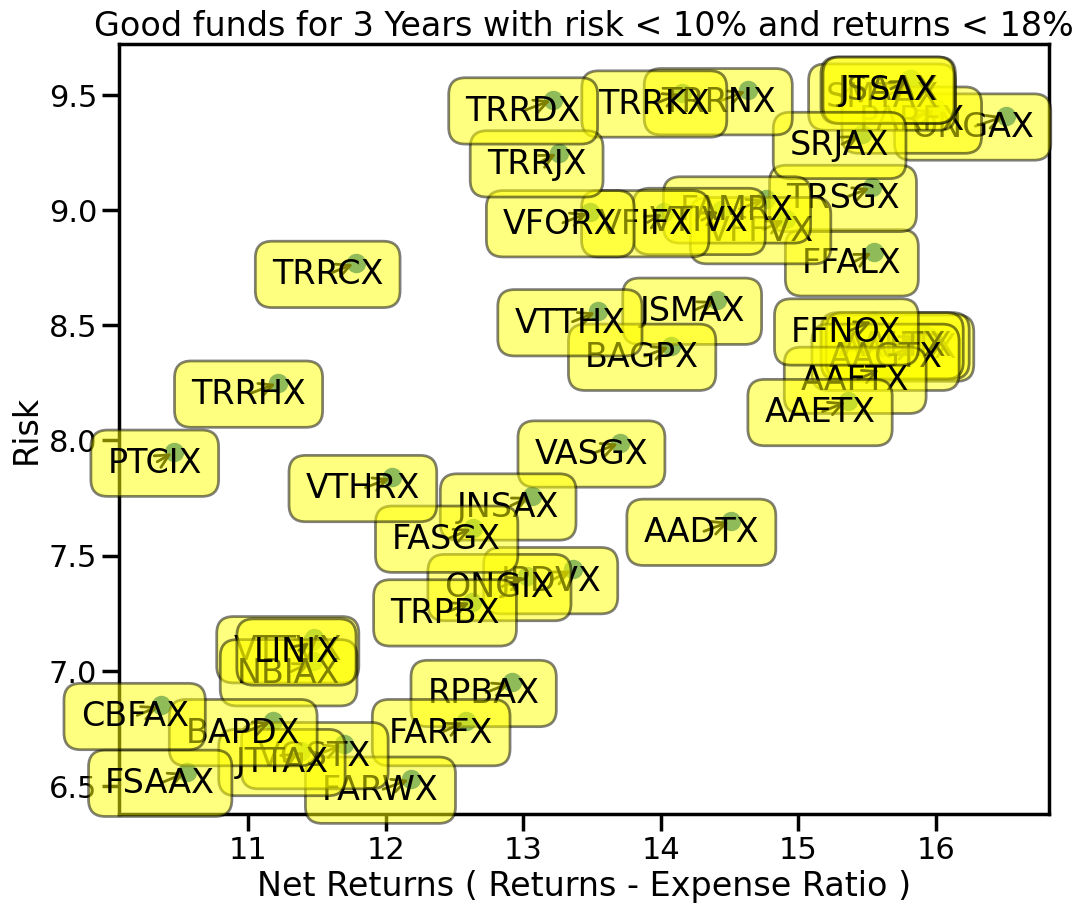

In [190]:
# plot a graph of Returns Vs Standard deviation
good_funds = good_fund_three_yrs.query('Std_Dev<10 & Net_returns < 18')
plot_returns_Vs_risk(good_funds)
plt.title("Good funds for 3 Years with risk < 10% and returns < 18%")

#### 2.Good funds with risk >=10 and returns < 18 %

Text(0.5, 1.0, 'Good funds for 3 Years with risk >=10 and returns < 18 %')

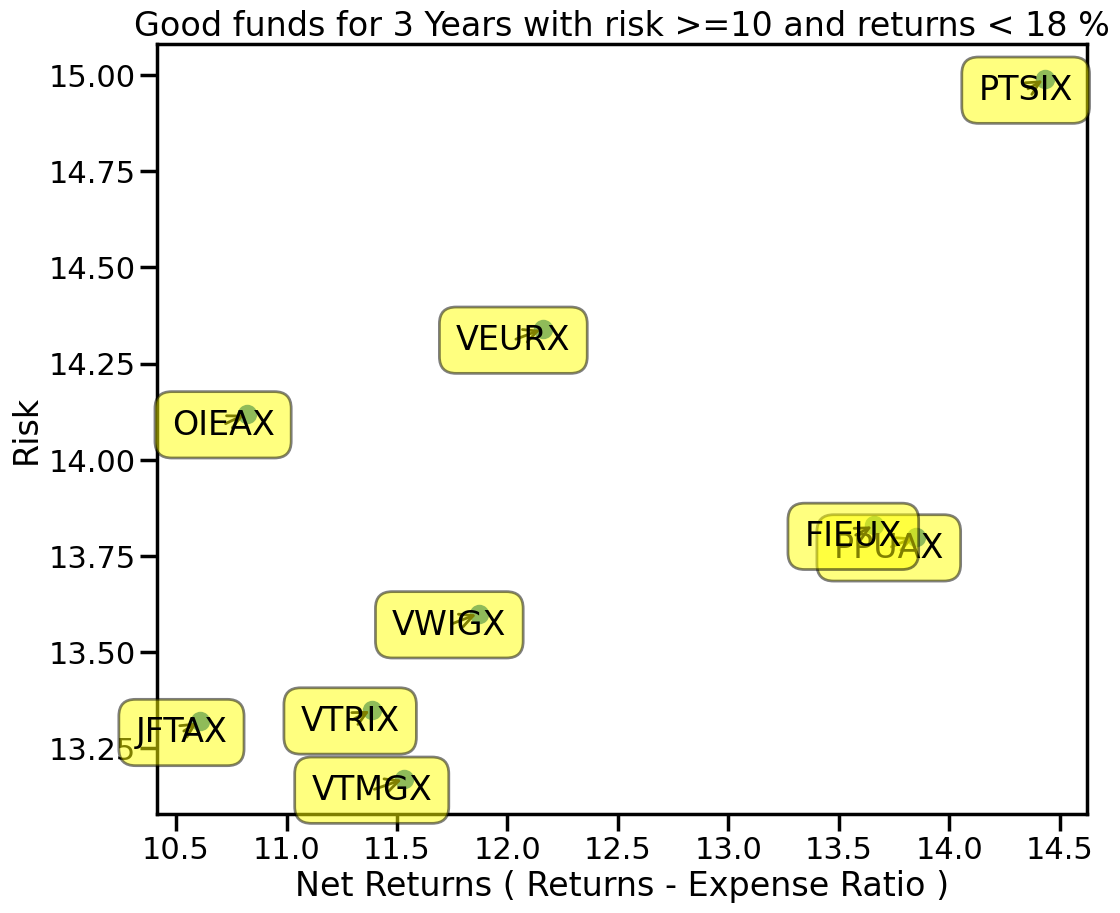

In [191]:

# plot a graph of Returns Vs Standard deviation
good_funds = good_fund_three_yrs.query('Std_Dev>=10 & Net_returns < 18')
plot_returns_Vs_risk(good_funds)
plt.title("Good funds for 3 Years with risk >=10 and returns < 18 %")

#### 3.Good funds with risk < 12 and returns > 18 %

Text(0.5, 1.0, 'Good funds for 3 Years  with risk < 12 and returns > 18%')

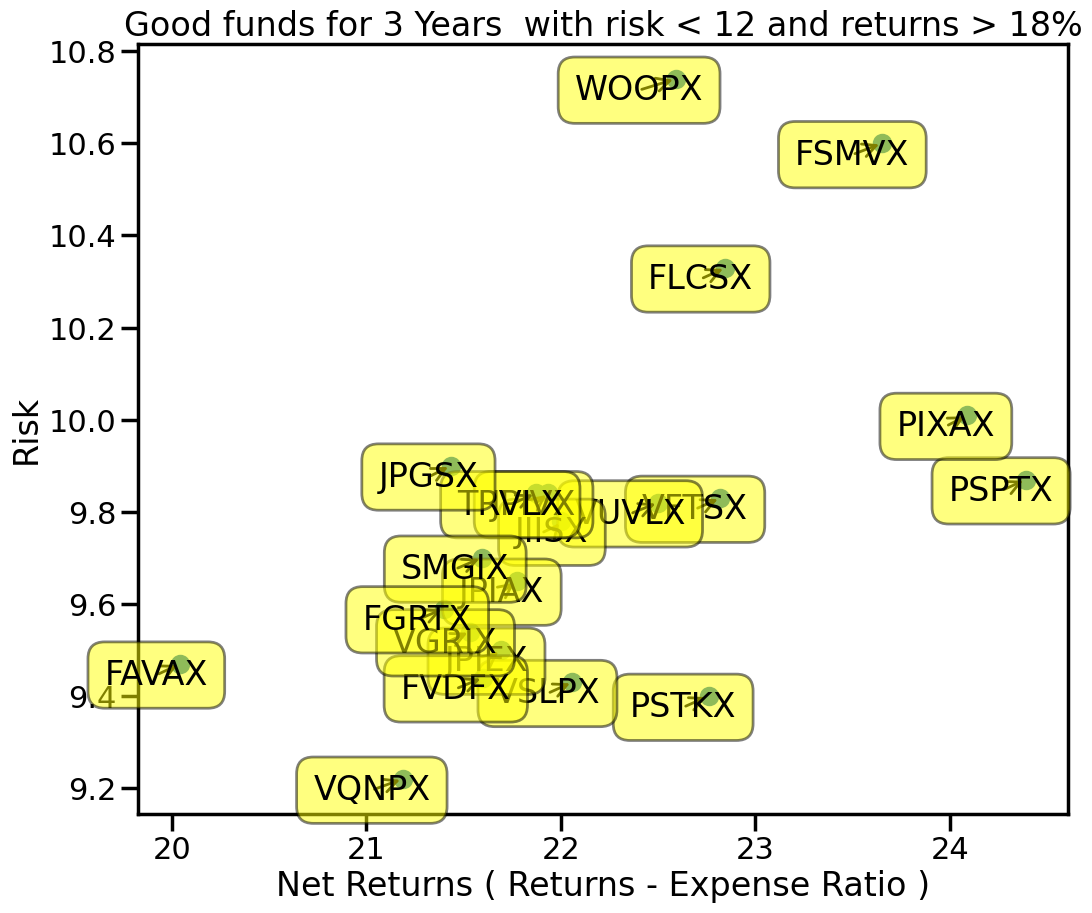

In [192]:
# plot a graph of Returns Vs Standard deviation
good_funds = good_fund_three_yrs.query('Std_Dev<12 & Net_returns > 18')
plot_returns_Vs_risk(good_funds)
plt.title("Good funds for 3 Years  with risk < 12 and returns > 18%")

### 1.1.1 More insight into top performing funds for 3 years investment

Now I will pick 5 funds from the top performing funds which I calculated above and see how these funds are behaving this year.
I will gather data from yahoo finance for daily returns.

I are using Yahoo finace since daily returns are not avilable on morning start website.


I will consider the following good funds:
FAVAX,VQNPX,PSTKX,PSPTX,PIXAX

In [193]:
import yfinance as yf
import pandas as pd

tickers = ['FAVAX', 'VQNPX', 'PSTKX', 'PSPTX', 'PIXAX']
start_date = '2014-01-01'
end_date = '2014-12-31'

# Download all data
data = yf.download(tickers, start=start_date, end=end_date)

# Check if 'Adj Close' exists
if isinstance(data.columns, pd.MultiIndex):
    if 'Adj Close' in data.columns.levels[1]:
        adj_close = data.loc[:, (slice(None), 'Adj Close')]
        adj_close.columns = adj_close.columns.droplevel(1)
        print(adj_close.head())
    else:
        print("'Adj Close' not found in returned data.")
else:
    print("Data is not in expected format. Columns:", data.columns)


/tmp/ipykernel_24038/4168372770.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed

'Adj Close' not found in returned data.


Calculate Returns using function pct_change()

In [194]:
rets = data.pct_change()
rets.head()

Price          Close                                              High  \
Ticker         FAVAX     PIXAX     PSPTX     PSTKX     VQNPX     FAVAX   
Date                                                                     
2014-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2014-01-03  0.000714  0.001525  0.000000 -0.001029  0.000510  0.000714   
2014-01-06 -0.001427 -0.001522 -0.001982 -0.002060 -0.002294 -0.001427   
2014-01-07  0.004286  0.006098  0.004965  0.006192  0.005878  0.004286   
2014-01-08 -0.000711 -0.001515 -0.000988 -0.001026  0.000508 -0.000711   

Price                                               ...      Open            \
Ticker         PIXAX     PSPTX     PSTKX     VQNPX  ...     FAVAX     PIXAX   
Date                                                ...                       
2014-01-02       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2014-01-03  0.001525  0.000000 -0.001029  0.000510  ...  0.000714  0.001525   
2014-01-06 -0.001522 -0.001982 -0.002060 -0.002294  ... -0.001427 -0.001522   
2014-01-07  0.006098  0.004965  0.006192  0.005878  ...  0.004286  0.006098   
2014-01-08 -0.001515 -0.000988 -0.001026  0.000508  ... -0.000711 -0.001515   

Price                                    Volume                          
Ticker         PSPTX     PSTKX     VQNPX  FAVAX PIXAX PSPTX PSTKX VQNPX  
Date                                                                     
2014-01-02       NaN       NaN       NaN    NaN   NaN   NaN   NaN   NaN  
2014-01-03  0.000000 -0.001029  0.000510    NaN   NaN   NaN   NaN   NaN  
2014-01-06 -0.001982 -0.002060 -0.002294    NaN   NaN   NaN   NaN   NaN  
2014-01-07  0.004965  0.006192  0.005878    NaN   NaN   NaN   NaN   NaN  
2014-01-08 -0.000988 -0.001026  0.000508    NaN   NaN   NaN   NaN   NaN  

[5 rows x 25 columns]

Find correlation between the selected funds and plot heat map showing correlation

In [195]:
corr = rets.corr()
corr

Price             Close                                              High  \
Ticker            FAVAX     PIXAX     PSPTX     PSTKX     VQNPX     FAVAX   
Price  Ticker                                                               
Close  FAVAX   1.000000  0.313997  0.962023  0.969829  0.969939  1.000000   
       PIXAX   0.313997  1.000000  0.295525  0.317192  0.344000  0.313997   
       PSPTX   0.962023  0.295525  1.000000  0.990133  0.982386  0.962023   
       PSTKX   0.969829  0.317192  0.990133  1.000000  0.991392  0.969829   
       VQNPX   0.969939  0.344000  0.982386  0.991392  1.000000  0.969939   
High   FAVAX   1.000000  0.313997  0.962023  0.969829  0.969939  1.000000   
       PIXAX   0.313997  1.000000  0.295525  0.317192  0.344000  0.313997   
       PSPTX   0.962023  0.295525  1.000000  0.990133  0.982386  0.962023   
       PSTKX   0.969829  0.317192  0.990133  1.000000  0.991392  0.969829   
       VQNPX   0.969939  0.344000  0.982386  0.991392  1.000000  0.969939   
Low    FAVAX   1.000000  0.313997  0.962023  0.969829  0.969939  1.000000   
       PIXAX   0.313997  1.000000  0.295525  0.317192  0.344000  0.313997   
       PSPTX   0.962023  0.295525  1.000000  0.990133  0.982386  0.962023   
       PSTKX   0.969829  0.317192  0.990133  1.000000  0.991392  0.969829   
       VQNPX   0.969939  0.344000  0.982386  0.991392  1.000000  0.969939   
Open   FAVAX   1.000000  0.313997  0.962023  0.969829  0.969939  1.000000   
       PIXAX   0.313997  1.000000  0.295525  0.317192  0.344000  0.313997   
       PSPTX   0.962023  0.295525  1.000000  0.990133  0.982386  0.962023   
       PSTKX   0.969829  0.317192  0.990133  1.000000  0.991392  0.969829   
       VQNPX   0.969939  0.344000  0.982386  0.991392  1.000000  0.969939   
Volume FAVAX        NaN       NaN       NaN       NaN       NaN       NaN   
       PIXAX        NaN       NaN       NaN       NaN       NaN       NaN   
       PSPTX        NaN       NaN       NaN       NaN       NaN       NaN   
       PSTKX        NaN       NaN       NaN       NaN       NaN       NaN   
       VQNPX        NaN       NaN       NaN       NaN       NaN       NaN   

Price                                                  ...      Open  \
Ticker            PIXAX     PSPTX     PSTKX     VQNPX  ...     FAVAX   
Price  Ticker                                          ...             
Close  FAVAX   0.313997  0.962023  0.969829  0.969939  ...  1.000000   
       PIXAX   1.000000  0.295525  0.317192  0.344000  ...  0.313997   
       PSPTX   0.295525  1.000000  0.990133  0.982386  ...  0.962023   
       PSTKX   0.317192  0.990133  1.000000  0.991392  ...  0.969829   
       VQNPX   0.344000  0.982386  0.991392  1.000000  ...  0.969939   
High   FAVAX   0.313997  0.962023  0.969829  0.969939  ...  1.000000   
       PIXAX   1.000000  0.295525  0.317192  0.344000  ...  0.313997   
       PSPTX   0.295525  1.000000  0.990133  0.982386  ...  0.962023   
       PSTKX   0.317192  0.990133  1.000000  0.991392  ...  0.969829   
       VQNPX   0.344000  0.982386  0.991392  1.000000  ...  0.969939   
Low    FAVAX   0.313997  0.962023  0.969829  0.969939  ...  1.000000   
       PIXAX   1.000000  0.295525  0.317192  0.344000  ...  0.313997   
       PSPTX   0.295525  1.000000  0.990133  0.982386  ...  0.962023   
       PSTKX   0.317192  0.990133  1.000000  0.991392  ...  0.969829   
       VQNPX   0.344000  0.982386  0.991392  1.000000  ...  0.969939   
Open   FAVAX   0.313997  0.962023  0.969829  0.969939  ...  1.000000   
       PIXAX   1.000000  0.295525  0.317192  0.344000  ...  0.313997   
       PSPTX   0.295525  1.000000  0.990133  0.982386  ...  0.962023   
       PSTKX   0.317192  0.990133  1.000000  0.991392  ...  0.969829   
       VQNPX   0.344000  0.982386  0.991392  1.000000  ...  0.969939   
Volume FAVAX        NaN       NaN       NaN       NaN  ...       NaN   
       PIXAX        NaN       NaN       NaN       NaN  ...       NaN   
       PSPTX        NaN       NaN       NaN

Text(0.5, 1.0, 'Correlation between Funds')

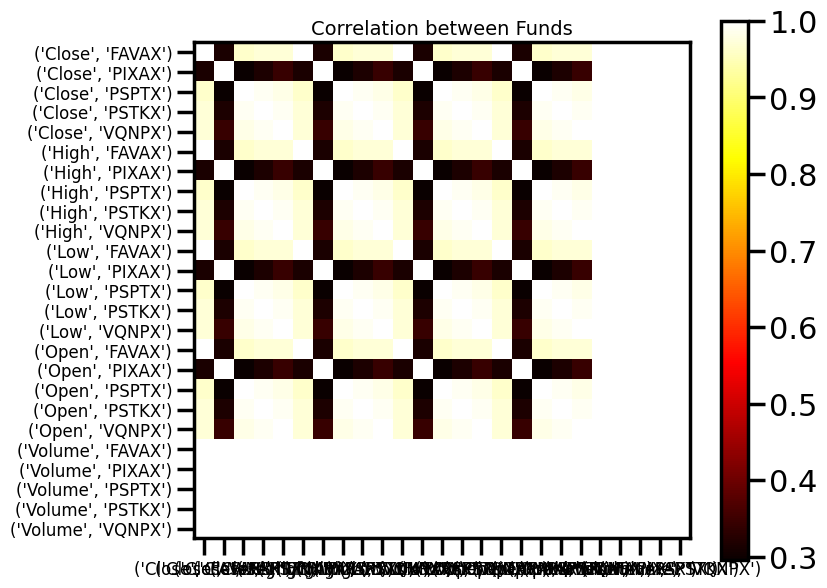

In [196]:
#Plot heat map for correlation
plt.figure(figsize=(8,7))
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, fontsize = 12)
plt.yticks(range(len(corr)), corr.columns, fontsize = 12);
plt.title("Correlation between Funds",fontsize=14)

Show histogram of selected funds

array([[<Axes: title={'center': "('Close', 'FAVAX')"}>,
        <Axes: title={'center': "('Close', 'PIXAX')"}>,
        <Axes: title={'center': "('Close', 'PSPTX')"}>,
        <Axes: title={'center': "('Close', 'PSTKX')"}>,
        <Axes: title={'center': "('Close', 'VQNPX')"}>],
       [<Axes: title={'center': "('High', 'FAVAX')"}>,
        <Axes: title={'center': "('High', 'PIXAX')"}>,
        <Axes: title={'center': "('High', 'PSPTX')"}>,
        <Axes: title={'center': "('High', 'PSTKX')"}>,
        <Axes: title={'center': "('High', 'VQNPX')"}>],
       [<Axes: title={'center': "('Low', 'FAVAX')"}>,
        <Axes: title={'center': "('Low', 'PIXAX')"}>,
        <Axes: title={'center': "('Low', 'PSPTX')"}>,
        <Axes: title={'center': "('Low', 'PSTKX')"}>,
        <Axes: title={'center': "('Low', 'VQNPX')"}>],
       [<Axes: title={'center': "('Open', 'FAVAX')"}>,
        <Axes: title={'center': "('Open', 'PIXAX')"}>,
        <Axes: title={'center': "('Open', 'PSPTX')"}>,
       

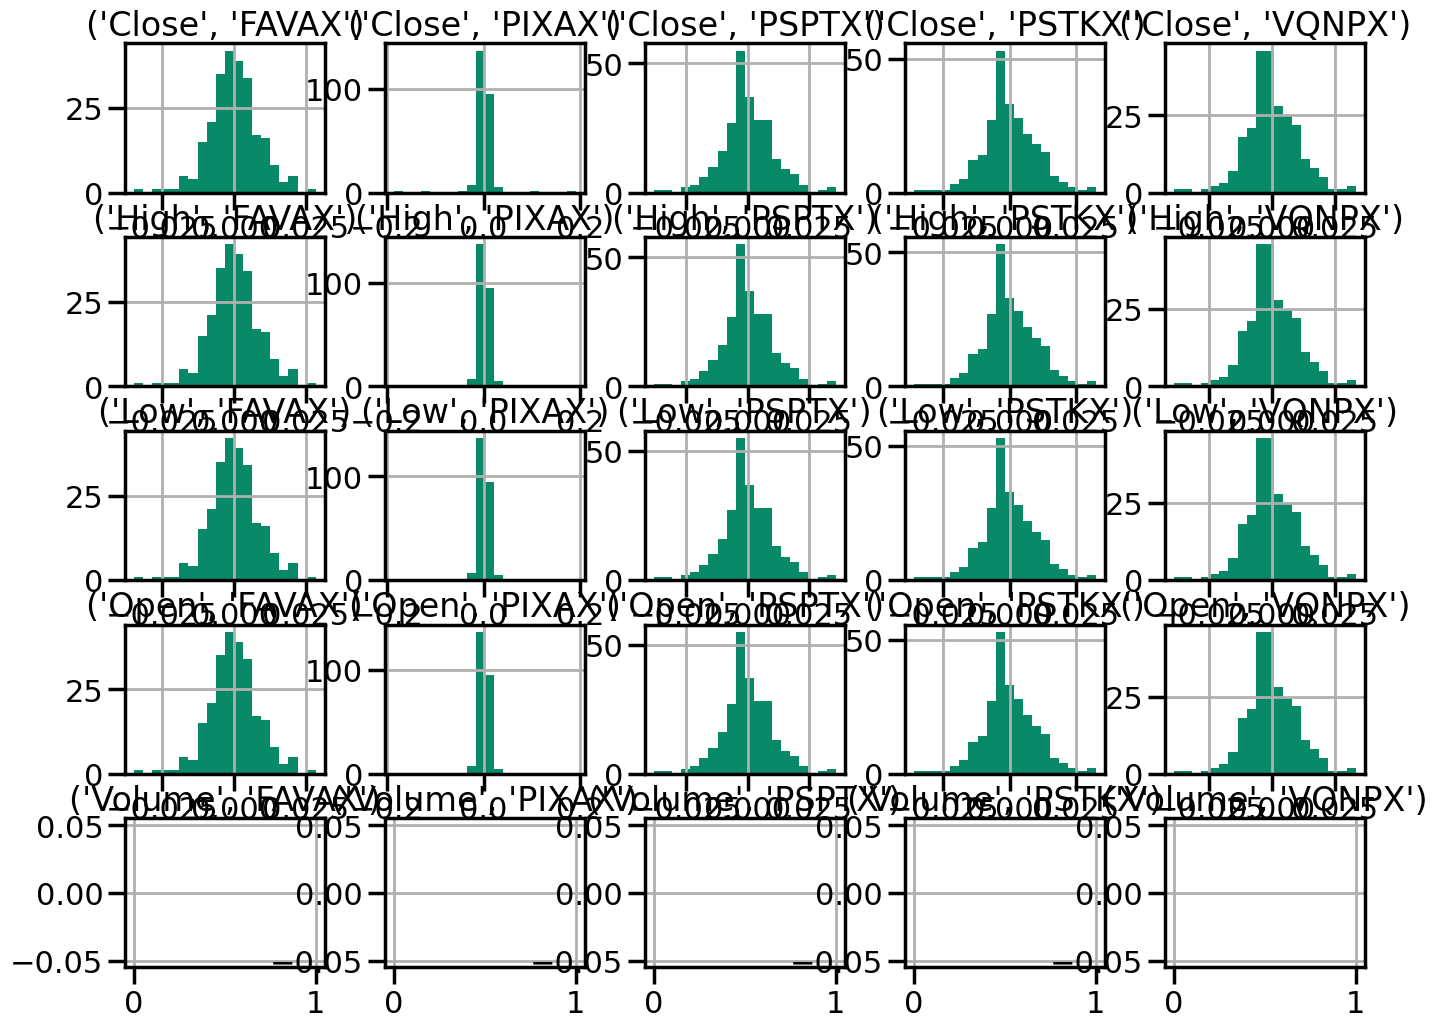

In [197]:

rets.diff().hist(figsize=(16,12),bins=20,color="#088A68")


Show Percentage returns for each fund for current year

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6')])

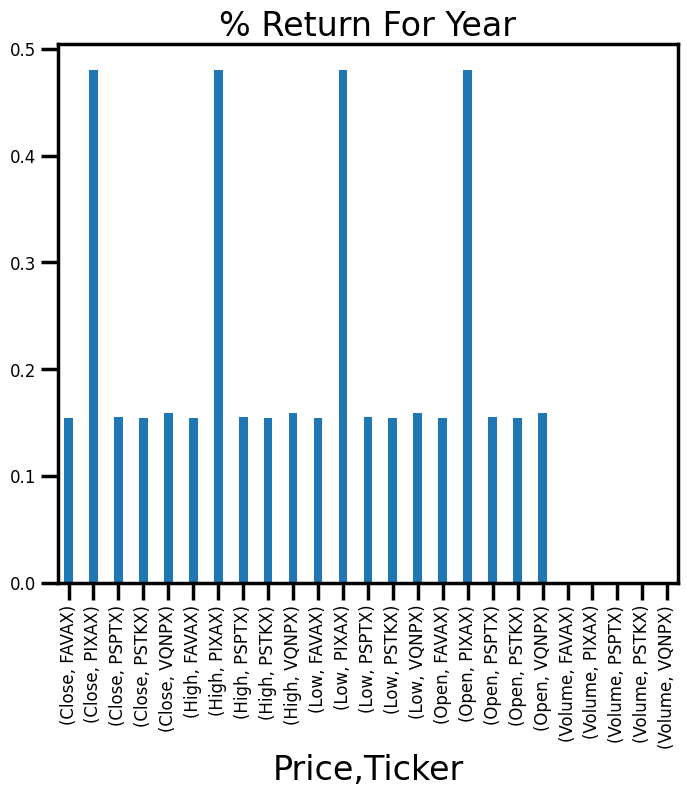

In [198]:
plt.figure(figsize=(8,7))
rets.sum().plot(kind='bar',title="% Return For Year", width=0.35)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

Plot chart of cumulative sum of selcted funds.

<Figure size 1200x600 with 0 Axes>

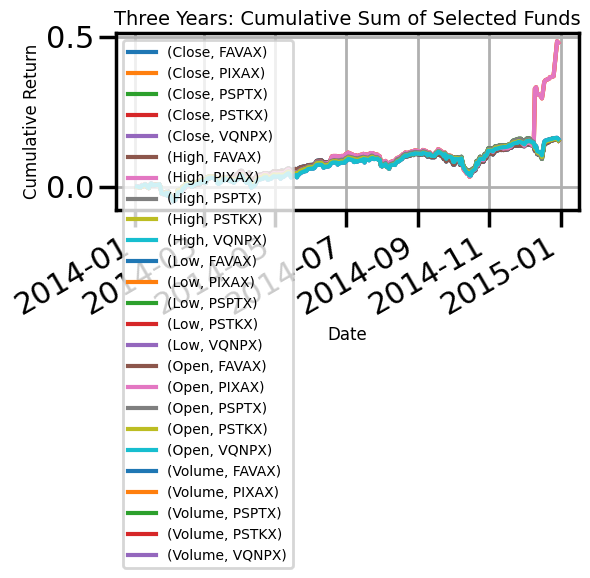

In [199]:
ts = rets.cumsum()

# Set the figure size and improve styling
plt.figure(figsize=(12, 6))  # Wider and taller plot
ts.plot()

plt.title("Three Years: Cumulative Sum of Selected Funds", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.show()


From the above analysis I can say that this funds amongst the selected 5 funds, PSPTX is performing slightly better than the rest.

### Summary for 3 years investment.

I used Random Foreset classifer to predict top performing funds for 3 year investment. I used cross validtaion to find the best value for n_estimator and predicted top 20 funds for investment.
Based on our analysis PSPTX, PIXAX ,FSMVX, FLCSX, VFTSX are one of the top performing funds for 3 year investments which give more tha 23% returns with less tha 11% risk.
Also fund with less expense ratio give more returns for 3 year investment.

### 1.2 Predict Good funds for 5 years investment

Now, I will predict which funds are top performing fro 5 year investment.
I will repeat the Procedure which I did for 3 years investment using Random forest Classifier.

In [200]:
# gather 5 year data for each fund
fund_data = pd.read_csv("../Fund_Data/Fund_Stats_Annualized_data/Fund_statistics_5years.csv").drop(u'Unnamed: 0',axis =1)
fund_data.head()

Fund_Ticker                   Benchmark_Index  R_Squared  Beta  Alpha  \
0       FRIFX                  MSCI ACWI NR USD      55.22  0.30   8.48   
1       VTWNX  Morningstar Moderate Target Risk      98.97  1.06   0.35   
2       JNBAX  Morningstar Moderate Target Risk      88.95  0.96   0.44   
3       FIOFX  Morningstar Moderate Target Risk      98.47  1.37  -1.67   
4       PTTRX       Barclays US Agg Bond TR USD      59.01  0.98   1.02   

   Treynor_Ratio Currency  Year_Trailing  Std_Dev  Return  Sharpe_Ratio  \
0          40.52      USD              5     5.84   12.18          1.99   
1           9.38      USD              5     9.03   10.06          1.10   
2           9.48      USD              5     8.62    9.20          1.06   
3           7.67      USD              5    11.65   10.58          0.92   
4           5.08      USD              5     3.60    5.06          1.37   

   Sortino_Ratio  
0           3.85  
1           1.91  
2           1.74  
3           1.51  
4           2.32

Find Expense ratio of each fund and calculate net returns  =  returns - Expense ratio

In [201]:
fund_data['Expense_Ratio'] = [0.0]*len(fund_data)
i=0
for ticker in fund_data.Fund_Ticker:
    try:
        fund_data['Expense_Ratio'][i] = fund_returns[ticker]['Annual_Net_Exp_Ratio'][-5:].mean()
        
    except:
        fund_data['Expense_Ratio'][i] = np.nan

    i=i+1

fund_data['Expense_Ratio'] = fund_data['Expense_Ratio'].ffill()
fund_data['Net_returns'] = fund_data['Return'] - fund_data['Expense_Ratio']

fund_data.head()

/tmp/ipykernel_24038/1233088180.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  fund_data['Expense_Ratio'][i] = fund_returns[ticker]['Annual_Net_Exp_Ratio'][-5:].mean()
/tmp/ipykernel_24038/1233088180.py:5: SettingWithCopyWarning: 
A val

Fund_Ticker                   Benchmark_Index  R_Squared  Beta  Alpha  \
0       FRIFX                  MSCI ACWI NR USD      55.22  0.30   8.48   
1       VTWNX  Morningstar Moderate Target Risk      98.97  1.06   0.35   
2       JNBAX  Morningstar Moderate Target Risk      88.95  0.96   0.44   
3       FIOFX  Morningstar Moderate Target Risk      98.47  1.37  -1.67   
4       PTTRX       Barclays US Agg Bond TR USD      59.01  0.98   1.02   

   Treynor_Ratio Currency  Year_Trailing  Std_Dev  Return  Sharpe_Ratio  \
0          40.52      USD              5     5.84   12.18          1.99   
1           9.38      USD              5     9.03   10.06          1.10   
2           9.48      USD              5     8.62    9.20          1.06   
3           7.67      USD              5    11.65   10.58          0.92   
4           5.08      USD              5     3.60    5.06          1.37   

   Sortino_Ratio  Expense_Ratio  Net_returns  
0           3.85          0.888       11.292  
1           1.91          1.736        8.324  
2           1.74          0.656        8.544  
3           1.51          0.070       10.510  
4           2.32          0.460        4.600


A good fund should give best returns and it should have the following values :
    
* R sqaured : between 85-100.
* Return : as high as possible ( I consider return > 10 )
* Beta : greater than .5
* alpha : greater than 0
* sharpe ratio : greater than 0
* Standard deviation : low ( I cosidered std deviation <15 )

In [202]:
'''
convert quality to zero and 1
R_sqr = 85 and 100
beta = >.5
alpha = >0
std < 15
Sharpe_Ratio>0
Return>10
'''
 
def parse_returns(row):
    if((row.R_Squared >=85) & (row.R_Squared <=100) &
       (row.Beta > .5) &
       (row.Alpha >0) &
       (row.Std_Dev <15) &
       (row.Sharpe_Ratio  >0)&
       (row.Net_returns > 10)
       ):
        return 1
    else:
        return 0

In [203]:
Y=create_score(fund_data)

Create X and Y array for further analysis. Consider alpha, Beta, Std Dev, Returns, Sharpe Ratio, Expense Ratio as X and good_bad_indicator as Y.

In [204]:
X_df = fund_data.drop(fund_data.columns[[0,1,6,7,13]], axis=1)
X= X_df.values
Y = np.array(Y)

Use Random forest classifer and cross validation for number of trees ranging from 1 to 41 to find out which trees gives more accuracy.

In [205]:
# range of trees from 1 to 40
from sklearn.model_selection import cross_val_score
no_trees = range(1,41)

# number of Folds =10
k_fold=10 

# define a datafarme to store result of crosss validation for each iteration.
df_random_forest = pd.DataFrame()
df_random_forest['Num_Trees'] = [0]*len(no_trees)
df_random_forest['Score'] = [[]]*len(no_trees)

# compute score for various number of trees using RandomForestClassifier.
for i in no_trees:    
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators=i)
    scores = cross_val_score(forest, X, Y, cv=k_fold)
    df_random_forest['Num_Trees'][i-1]= i
    df_random_forest['Score'][i-1]=scores

# Display head of result
df_random_forest.head()

/tmp/ipykernel_24038/862372642.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_random_forest['Num_Trees'][i-1]= i
/tmp/ipykernel_24038/862372642.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

Num_Trees                                              Score
0          1  [0.9603960396039604, 0.9702970297029703, 0.990...
1          2  [0.9603960396039604, 0.9801980198019802, 0.970...
2          3  [0.9801980198019802, 0.9801980198019802, 0.970...
3          4  [0.9801980198019802, 0.9900990099009901, 0.990...
4          5  [0.9801980198019802, 0.9900990099009901, 0.980...

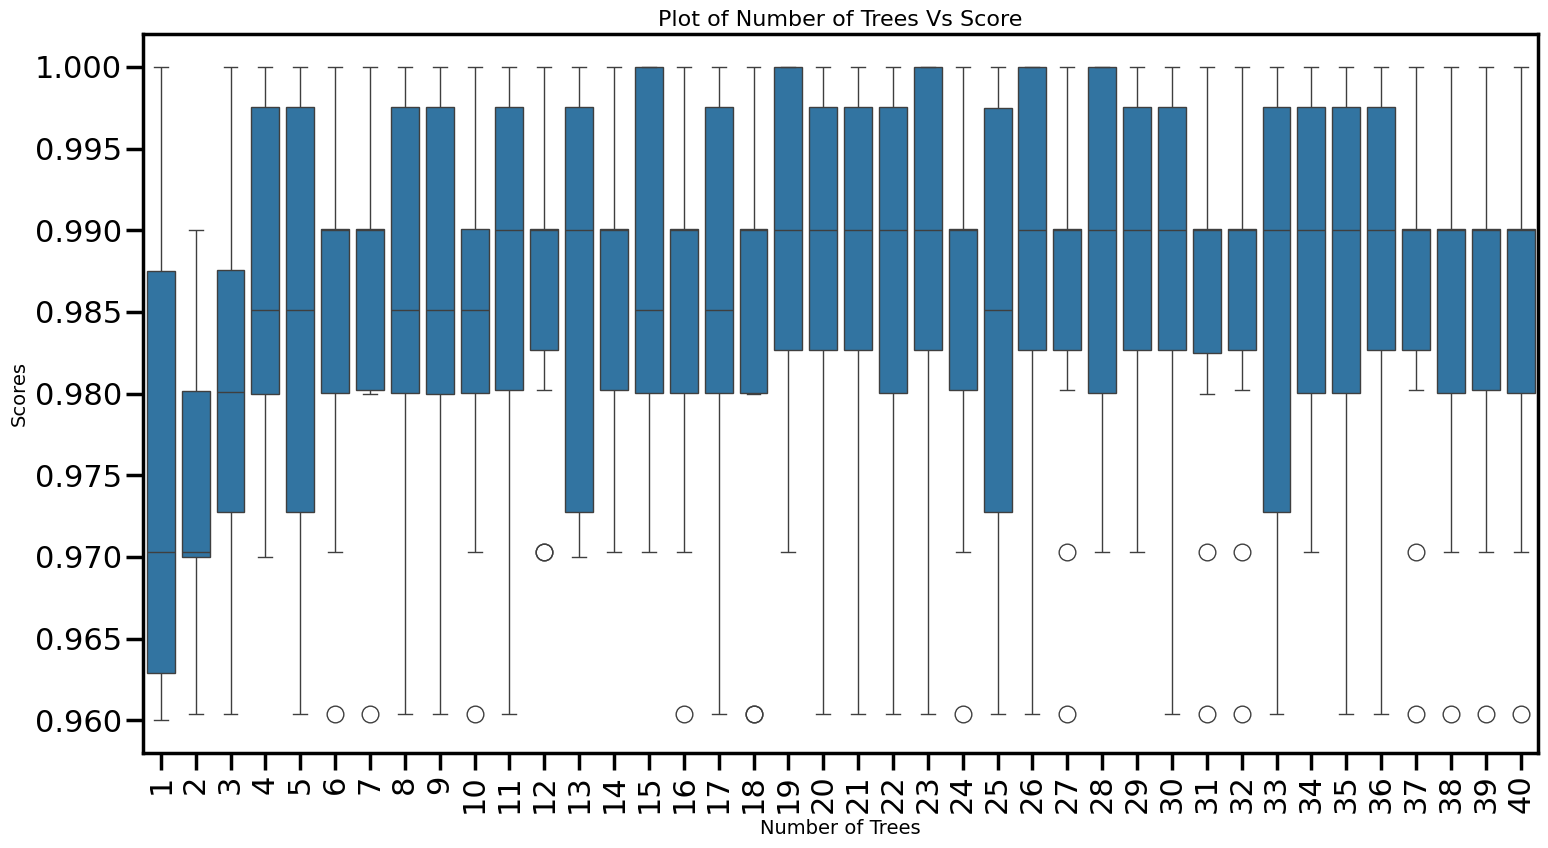

In [206]:
# Convert wide-form df_random_forest to long-form for Seaborn
long_df = df_random_forest.explode('Score')  # Explode the list of scores
long_df['Score'] = long_df['Score'].astype(float)

# Plot
plt.figure(figsize=(16, 9))
sns.boxplot(data=long_df, x='Num_Trees', y='Score')

plt.title("Plot of Number of Trees Vs Score", fontsize=16)
plt.xlabel("Number of Trees", fontsize=14)
plt.ylabel("Scores", fontsize=14)
sns.set_context('poster')
plt.xticks(rotation=90)  # Optional: rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

Based on the above graph I can say that most of the estimators gives better accuracy e.g n_estimator = 4,9,12,13,14,23,2438,39.

Larger number of trees are preferable however it also increases execution time. So I will consider moderate number of trees giving better accuracy. n_Estimator = 18
Also caulate feature importance.

In [207]:
## Train random forest classifier on the wine data using 17 trees. 
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=17)
clf = clf.fit(X,Y)

# obtain the relative importance of the features 
feature_imp = clf.feature_importances_

#get column names
columns = X_df.columns

feature_imp

array([0.15229799, 0.07064571, 0.22667146, 0.24971865, 0.08036585,
       0.11698693, 0.02188042, 0.04536178, 0.03607121])

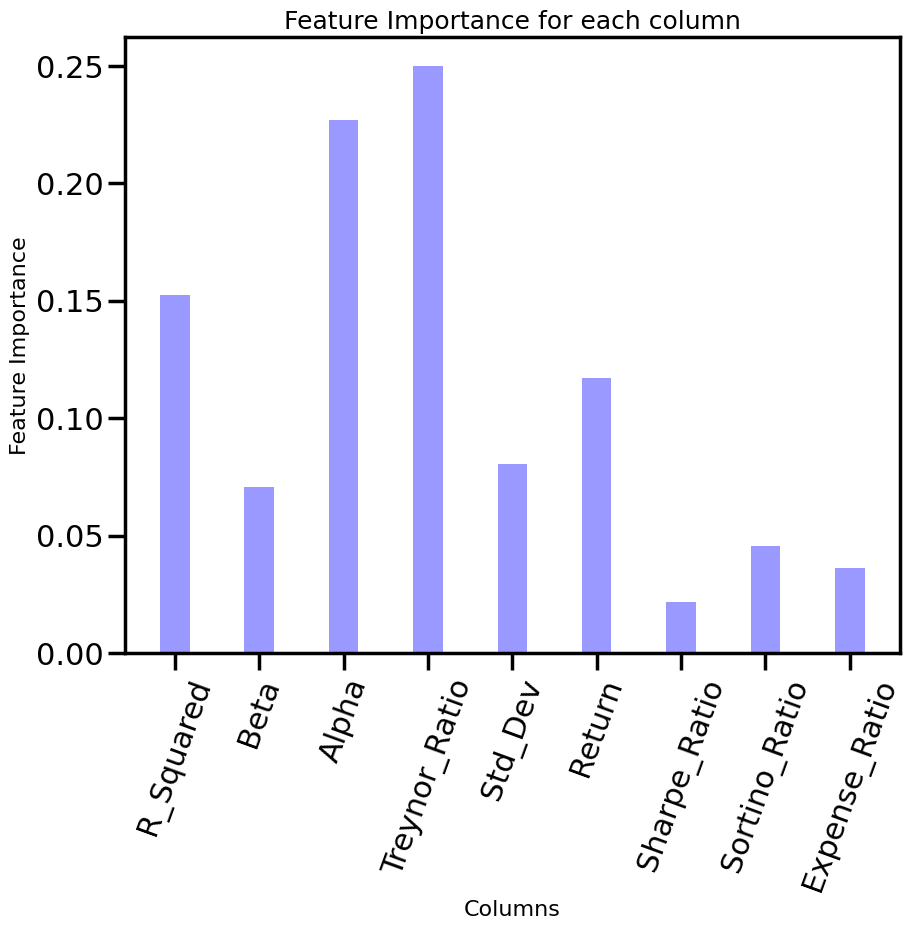

In [208]:
# Show a bar plot of feature imp of named features
index = np.arange(len(columns))
bar_width = 0.35
opacity = 0.4

plt.figure(figsize=(10,8))
plt.bar(index, feature_imp, bar_width,
                 alpha=opacity,
                 color='b',
                 label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column', fontsize =18)
plt.xticks(index, columns,rotation = 70)
plt.show()

Based on the above result I can sa that R sqyared,Alpha,Standard deviation and returns, Treynor ratio are the important fearures when determining the good mutual fund for 5 year investment.

Now predict the top perfoming funds using the random forest model fitted above.

In [209]:
Y_predict = clf.predict(X)
fund_data['Predicted_result'] = Y_predict

# Sort top performing fund in descending order of returns
good_fund_five_yrs = (
    fund_data.query("Predicted_result == 1")
    .sort_values(by='Net_returns', ascending=False)
    .reset_index(drop=True)
)

# View result
print(good_fund_five_yrs.head())


  Fund_Ticker Benchmark_Index  R_Squared  Beta  Alpha  Treynor_Ratio Currency  \
0       PIXAX  S&P 500 TR USD      90.71  1.06   2.62          23.91      USD   
1       PSPTX  S&P 500 TR USD      92.11  1.05   2.54          23.83      USD   
2       FLMVX  S&P 500 TR USD      86.39  0.90   2.99          24.61      USD   
3       PSTKX  S&P 500 TR USD      98.67  1.03   1.34          22.47      USD   
4       VSLPX  S&P 500 TR USD      98.73  1.04   0.42          21.39      USD   

   Year_Trailing  Std_Dev  Return  Sharpe_Ratio  Sortino_Ratio  Expense_Ratio  \
0              5    14.22   21.48          1.44           2.65           1.19   
1              5    13.98   20.10          1.38           2.51           0.64   
2              5    13.03   18.90          1.40           2.50           0.74   
3              5    13.93   17.81          1.25           2.18           0.50   
4              5    13.01   17.40          1.30           2.30           0.17   

   Net_returns  Predicted_

Show top performing 20 funds good for 5 years investment

In [210]:
len(good_fund_three_yrs)

79

First I will see he relationship between expense ratio and Returns using scatter plot for top performing funds

Text(0, 0.5, 'Expense Ratio')

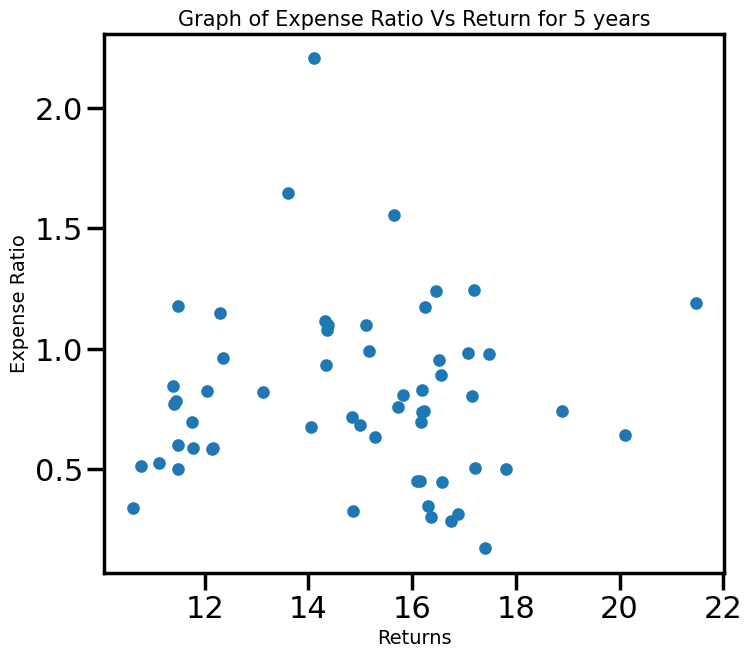

In [211]:
#Plot Returns  Vs Expense ratio
plt.figure(figsize=(8,7))
x=good_fund_five_yrs.query('Expense_Ratio>0').Return
y=good_fund_five_yrs.query('Expense_Ratio>0').Expense_Ratio
plt.scatter(x,y,s=50)
plt.title("Graph of Expense Ratio Vs Return for 5 years", fontsize=15)
plt.xlabel("Returns" , fontsize=14)
plt.ylabel("Expense Ratio", fontsize=14)


From the above plot I can say that top perfoming fund usually have low expense ratio.


Text(0.5, 1.0, 'Graph of good funds for 5 Years ')

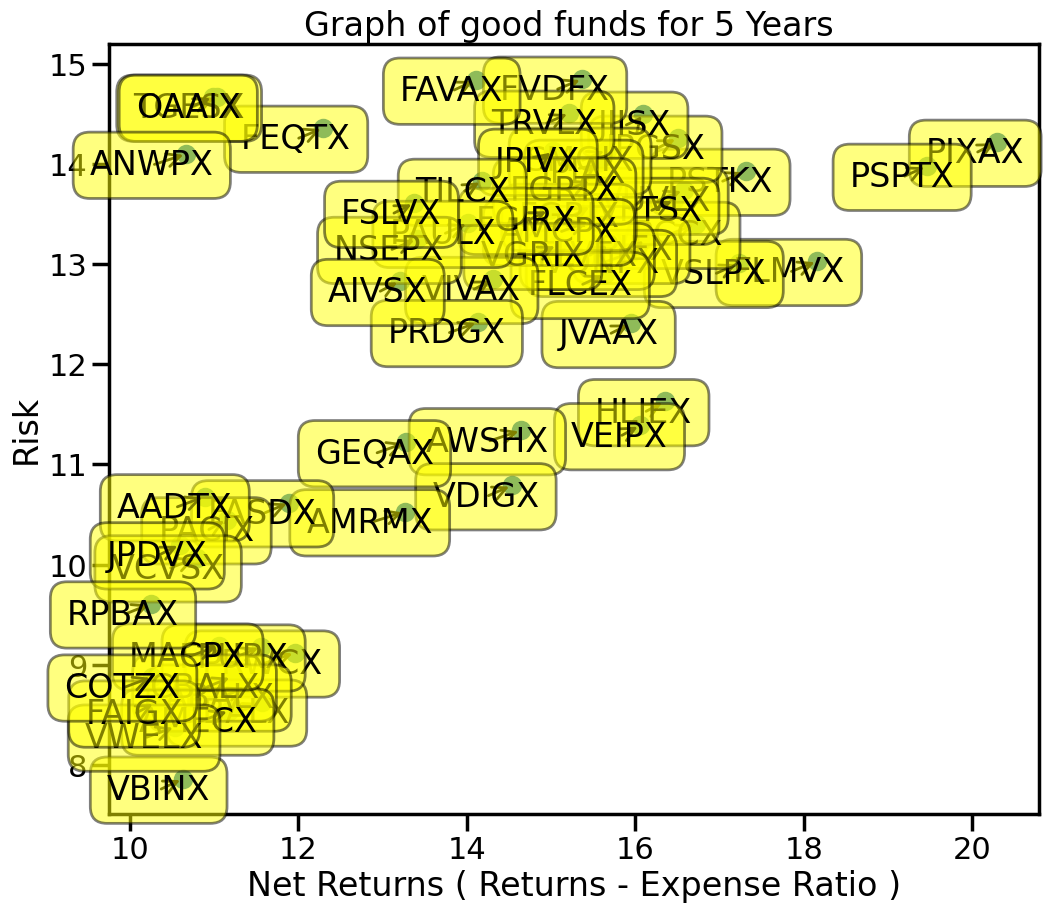

In [212]:
# plot a graph of Returns Vs Standard deviation
plot_returns_Vs_risk(good_fund_five_yrs)
plt.title("Graph of good funds for 5 Years ")

As I can see, that the funds are clustured together so the above graph is not readable.
I will divide the graph into 2 parts as follows :
1. Good funds with risk< 12 
2. Good funds with risk >=12 

#### 1. Good funds with risk< 12 

Text(0.5, 1.0, 'Good funds for 5 Years with risk < 12 %')

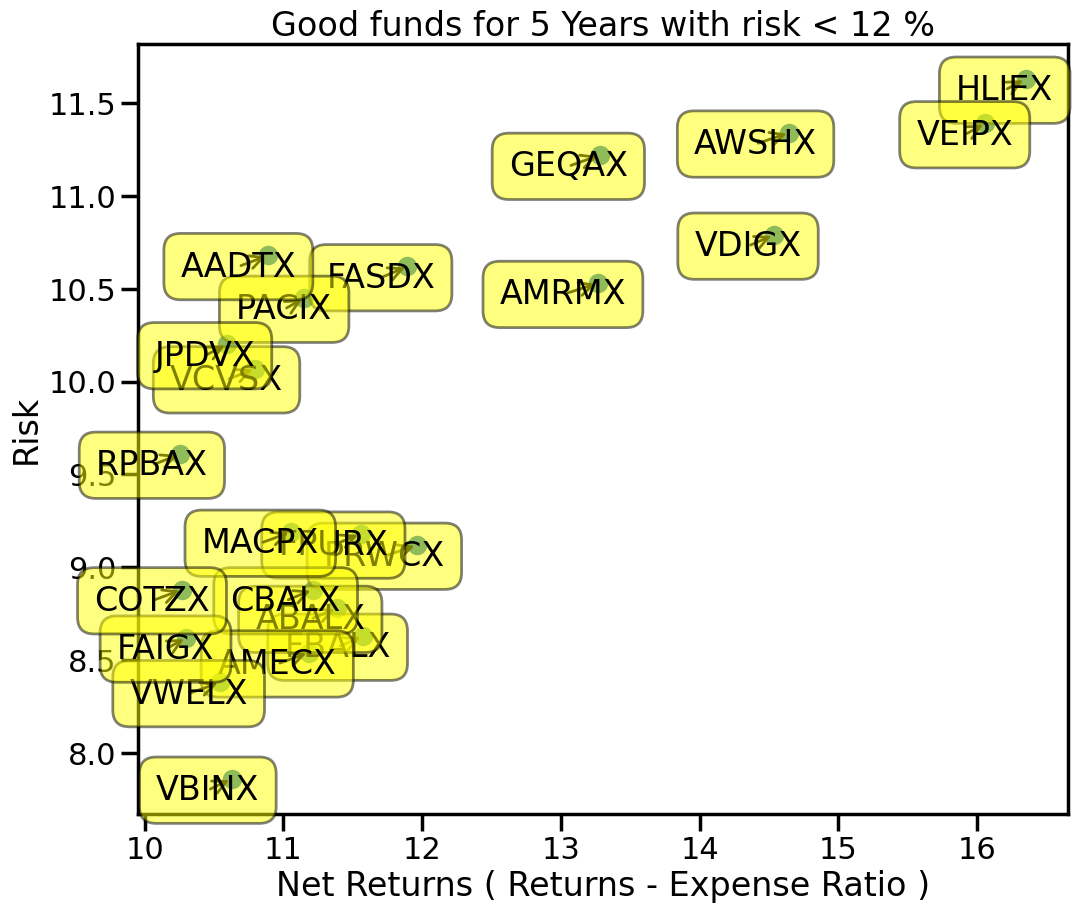

In [213]:
# plot a graph of Returns Vs Standard deviation
good_funds = good_fund_five_yrs.query('Std_Dev<12')
plot_returns_Vs_risk(good_funds)
plt.title("Good funds for 5 Years with risk < 12 %")

#### 2. Good funds with risk >=12 

Text(0.5, 1.0, 'Good funds for 5 Years with risk >= 12 %')

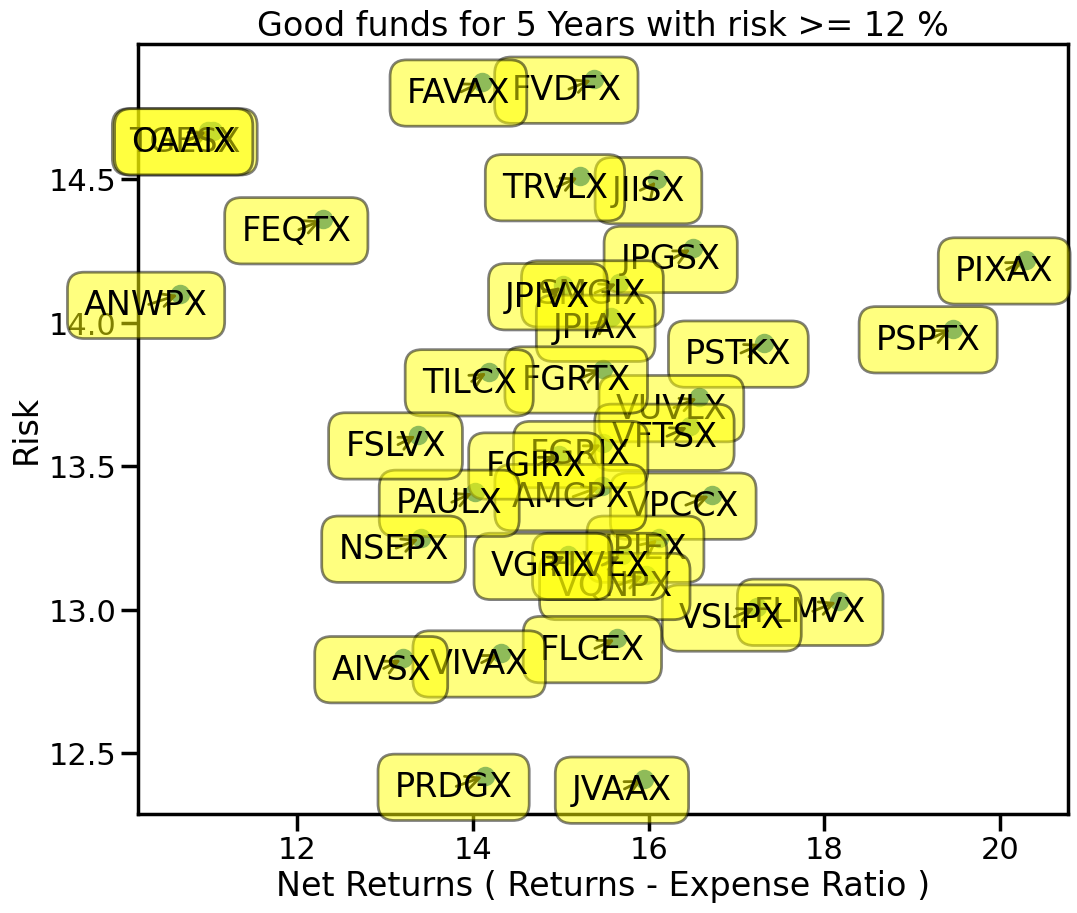

In [214]:
# plot a graph of Returns Vs Standard deviation
good_funds = good_fund_five_yrs.query('Std_Dev>=12')
plot_returns_Vs_risk(good_funds)
plt.title("Good funds for 5 Years with risk >= 12 %")

#### 1.2.1 More insight into good Funds for 5 years investment

Now I will pick 5 funds from the good funds which I calculated above and see how these funds are behaving this year. I will gather data from yahoo finance for daily returns.
I will consider the following good funds: 'PIXAX', 'PSTKX', 'FLMVX', 'VIVAX', 'VPCCX'.

In [215]:
import datetime

tickers = ['PIXAX', 'PSTKX', 'FLMVX', 'VIVAX', 'VPCCX']
print("Method 1: Handling MultiIndex structure")
try:
    raw_data = yf.download(tickers, 
                           start=datetime.datetime(2014, 1, 1), 
                           end=datetime.datetime(2014, 12, 31))
    
    print("Raw data columns:", raw_data.columns.names)
    print("Column levels:", raw_data.columns.nlevels)
    
    # Extract Adj Close for multiple tickers
    if raw_data.columns.nlevels > 1:
        data = raw_data['Adj Close']
    else:
        data = raw_data
        
    print("Extracted data shape:", data.shape)
    print("Data columns:", data.columns.tolist())
    
except Exception as e:
    print(f"Method 1 failed: {e}")


/tmp/ipykernel_24038/662925995.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers,
[*********************100%***********************]  5 of 5 completed

Method 1: Handling MultiIndex structure
Raw data columns: ['Price', 'Ticker']
Column levels: 2
Method 1 failed: 'Adj Close'


Find correlation between the selected funds and plot heat map showing correlation

In [216]:
corr = data.corr()

Text(0.5, 1.0, 'Correlation between Funds')

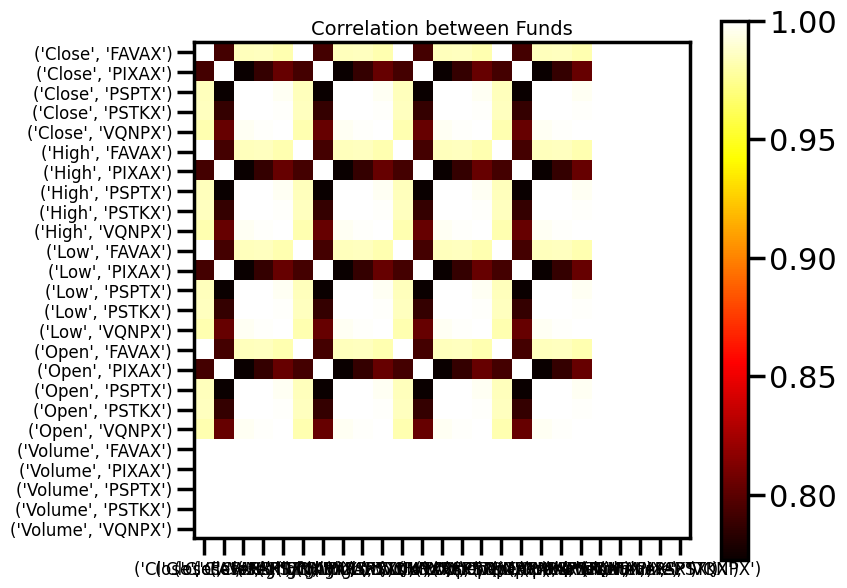

In [217]:
#Plot heat map for correlation
plt.figure(figsize=(8,7))
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, fontsize = 12)
plt.yticks(range(len(corr)), corr.columns, fontsize = 12);
plt.title("Correlation between Funds",fontsize=14)

Show histogram of selected funds


array([[<Axes: title={'center': "('Close', 'FAVAX')"}>,
        <Axes: title={'center': "('Close', 'PIXAX')"}>,
        <Axes: title={'center': "('Close', 'PSPTX')"}>,
        <Axes: title={'center': "('Close', 'PSTKX')"}>,
        <Axes: title={'center': "('Close', 'VQNPX')"}>],
       [<Axes: title={'center': "('High', 'FAVAX')"}>,
        <Axes: title={'center': "('High', 'PIXAX')"}>,
        <Axes: title={'center': "('High', 'PSPTX')"}>,
        <Axes: title={'center': "('High', 'PSTKX')"}>,
        <Axes: title={'center': "('High', 'VQNPX')"}>],
       [<Axes: title={'center': "('Low', 'FAVAX')"}>,
        <Axes: title={'center': "('Low', 'PIXAX')"}>,
        <Axes: title={'center': "('Low', 'PSPTX')"}>,
        <Axes: title={'center': "('Low', 'PSTKX')"}>,
        <Axes: title={'center': "('Low', 'VQNPX')"}>],
       [<Axes: title={'center': "('Open', 'FAVAX')"}>,
        <Axes: title={'center': "('Open', 'PIXAX')"}>,
        <Axes: title={'center': "('Open', 'PSPTX')"}>,
       

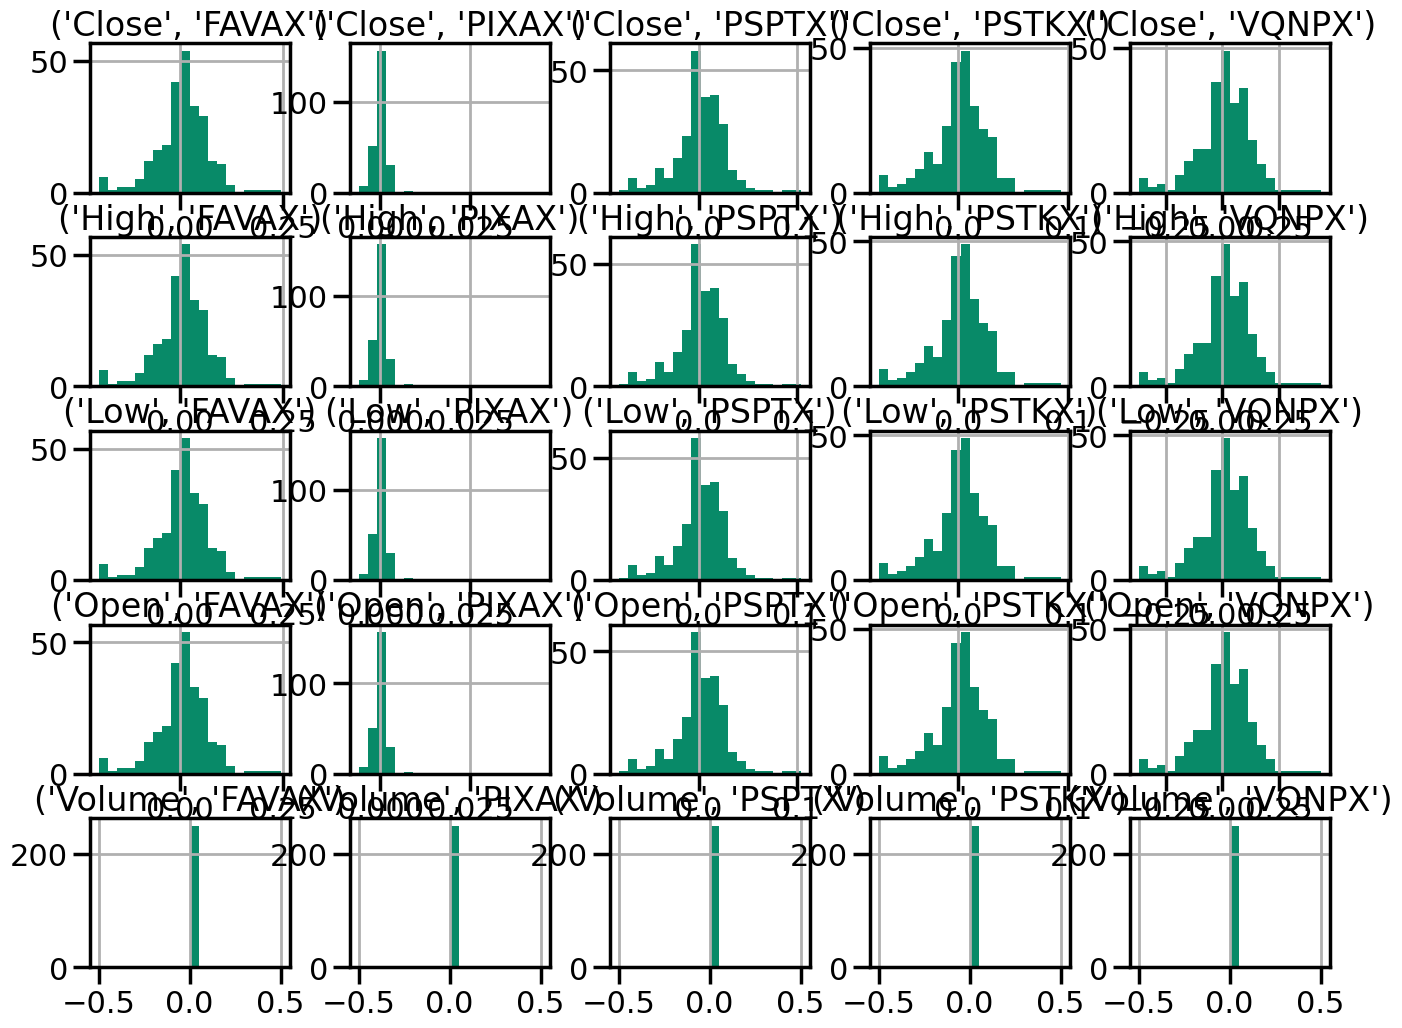

In [218]:
data.diff().hist(figsize=(16,12),bins=20,color="#088A68")

Show Percentage returns for each fund for current year

(array([   0., 1000., 2000., 3000., 4000., 5000.]),
 [Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000')])

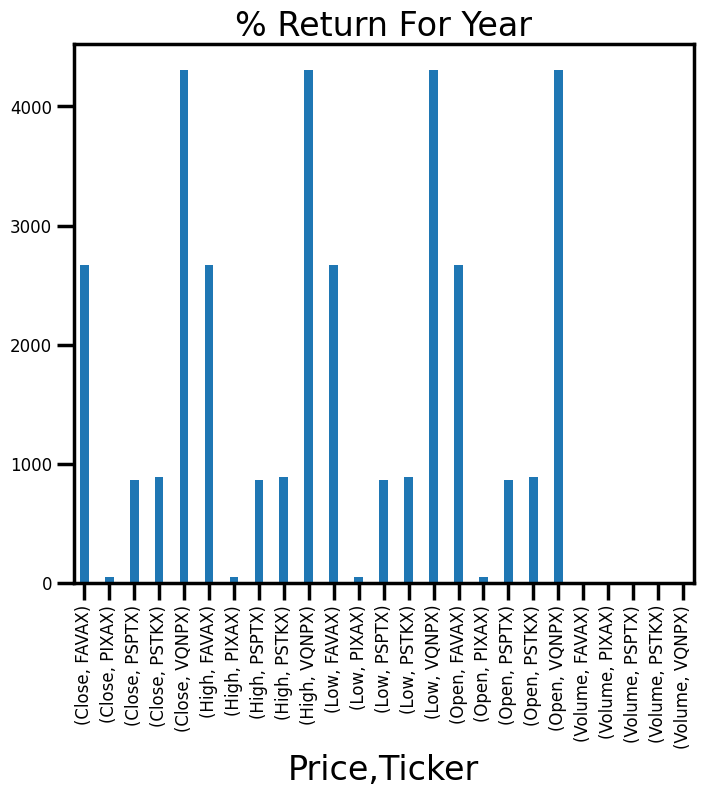

In [219]:
plt.figure(figsize=(8,7))
data.sum().plot(kind='bar',title="% Return For Year", width=0.35)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


Plot chart of cumulative sum of selcted funds.

Text(0.5, 1.0, ' Cumulative sum of Selected Funds')

<Figure size 640x480 with 0 Axes>

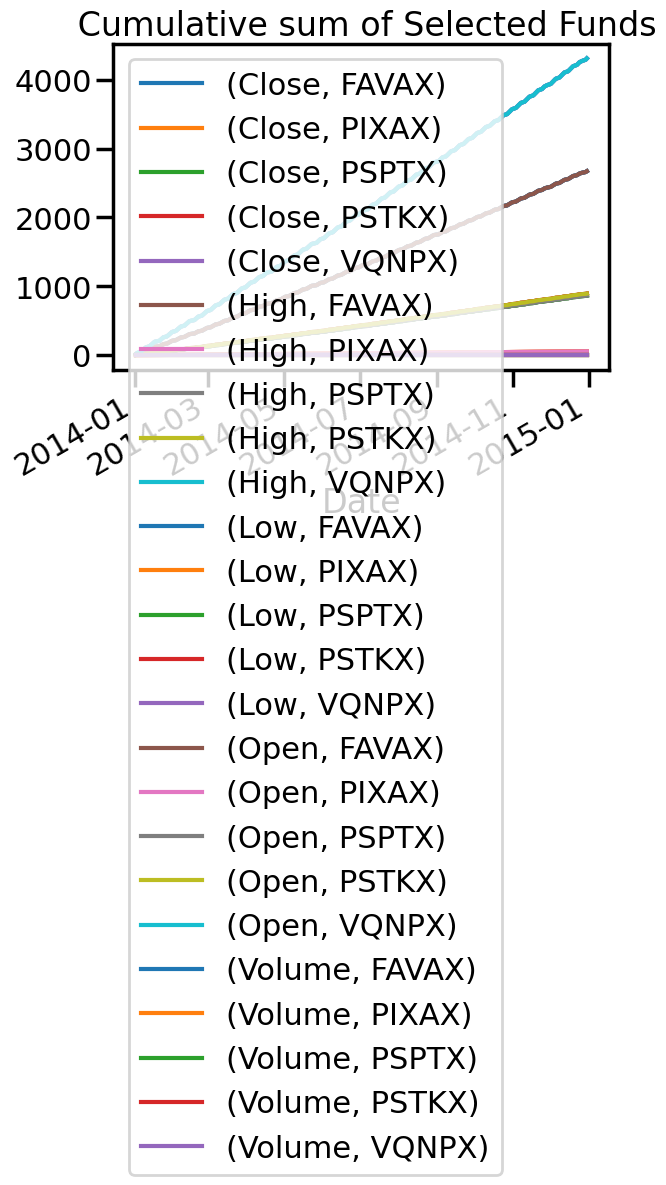

In [220]:
ts = data.cumsum()
plt.figure(); ts.plot(); plt.legend(loc='upper left')
plt.title(" Cumulative sum of Selected Funds")

Based on the above analysis I can say that VPCCX fund is performing better as compared to rest of the top performing fund for current year.

### Summary for 5 year investment

I used Random Foreset classifer to predict top performing funds for 5 year investment. I used cross validtaion to find the best value for n_estimator and predicted top 20 funds for investment.

Based on our analysis 'PIXAX', 'PSTKX', 'FLMVX', 'VIVAX', 'VPCCX' are one of the top performing funds for 5 year investments which give more tha 15% returns with less tha 13% risk.

Also fund with less expense ratio give more returns for 5 year investment.

### 1.3 Predict Good funds for 10 years investment

I will repeat the Procedure which I did for 3 years and 5 years investment using Random forest Classifier.

In [221]:
# gather 10 year data for each fund
fund_data = pd.read_csv("../Fund_Data/Fund_Stats_Annualized_data/Fund_statistics_10years.csv").drop(u'Unnamed: 0',axis =1)
fund_data.head()

Fund_Ticker              Benchmark_Index  R_Squared  Beta  Alpha  \
0       FRIFX             MSCI ACWI NR USD      56.99  0.45   2.81   
1       PTTRX  Barclays US Agg Bond TR USD      69.53  1.01   1.24   
2       VGPMX             MSCI ACWI NR USD      56.66  1.44  -4.60   
3       PRGTX             MSCI ACWI NR USD      78.52  1.12   6.63   
4       FOSFX      MSCI ACWI Ex USA NR USD      95.43  1.03  -0.62   

   Treynor_Ratio Currency  Year_Trailing  Std_Dev  Return  Sharpe_Ratio  \
0          11.99      USD             10     9.78    6.92          0.58   
1           4.54      USD             10     3.92    6.11          1.13   
2          -0.51      USD             10    31.67    0.78          0.14   
3          11.10      USD             10    20.84   13.94          0.66   
4           3.66      USD             10    19.83    5.29          0.29   

   Sortino_Ratio  
0           0.78  
1           2.00  
2           0.20  
3           1.02  
4           0.40

Find Expense ratio of ech fund and calculate net returns = returns - Expense ratio

In [222]:
fund_data['Expense_Ratio'] = [0.0]*len(fund_data)
i=0
for ticker in fund_data.Fund_Ticker:
    try:
        fund_data['Expense_Ratio'][i] = fund_returns[ticker]['Annual_Net_Exp_Ratio'][-10:].mean()
        
    except:
        fund_data['Expense_Ratio'][i] = np.nan
 
    i=i+1
 
fund_data['Expense_Ratio'] = fund_data['Expense_Ratio'].ffill()
fund_data['Net_returns'] = fund_data['Return'] - fund_data['Expense_Ratio']
 
fund_data.head()

/tmp/ipykernel_24038/410937427.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  fund_data['Expense_Ratio'][i] = fund_returns[ticker]['Annual_Net_Exp_Ratio'][-10:].mean()
/tmp/ipykernel_24038/410937427.py:5: SettingWithCopyWarning: 
A valu

Fund_Ticker              Benchmark_Index  R_Squared  Beta  Alpha  \
0       FRIFX             MSCI ACWI NR USD      56.99  0.45   2.81   
1       PTTRX  Barclays US Agg Bond TR USD      69.53  1.01   1.24   
2       VGPMX             MSCI ACWI NR USD      56.66  1.44  -4.60   
3       PRGTX             MSCI ACWI NR USD      78.52  1.12   6.63   
4       FOSFX      MSCI ACWI Ex USA NR USD      95.43  1.03  -0.62   

   Treynor_Ratio Currency  Year_Trailing  Std_Dev  Return  Sharpe_Ratio  \
0          11.99      USD             10     9.78    6.92          0.58   
1           4.54      USD             10     3.92    6.11          1.13   
2          -0.51      USD             10    31.67    0.78          0.14   
3          11.10      USD             10    20.84   13.94          0.66   
4           3.66      USD             10    19.83    5.29          0.29   

   Sortino_Ratio  Expense_Ratio  Net_returns  
0           0.78          0.896        6.024  
1           2.00          0.447        5.663  
2           0.20          0.315        0.465  
3           1.02          2.526       11.414  
4           0.40          0.807        4.483


A good fund should give best returns and it should have the following values :
    
* R sqaured : between 70-100.
* Return : as high as possible ( I consider return > 10 )
* Beta : greater than .5
* alpha : greater than 0
* sharpe ratio : greater than 0
* Standard deviation : low ( I cosidered std deviation <20 )

In [223]:
'''
convert quality to zero and 1
R_sqr = 70 and 100
beta = >.5
alpha = >0
std < 20
Sharpe_Ratio>0
Return>9
'''
 
def parse_returns(row):
    if((row.R_Squared >=70) & (row.R_Squared <=100) &
     (row.Beta > 0.8) &
      (row.Alpha >= 0) &
      (row.Std_Dev <20) &
      (row.Sharpe_Ratio  >0)&
       (row.Net_returns > 9)
       ):
        return 1
    else:
        return 0
    
Y=create_score(fund_data)


Create X and Y arrays for further analysis. Consder X as matri of alpha, beta, sharpe ratio, expense ratio, etc. and Y as bad or good indicator.

In [224]:
X_df = fund_data.drop(fund_data.columns[[0,1,6,7,13]], axis=1)
X= X_df.values
Y = np.array(Y)

Use Random forest classifer and cross validation for number of trees ranging from 1 to 40 to find out which trees gives more accuracy. I will use f1 scoring parameter for cross validation
and plot the result

In [225]:
# range of trees from 1 to 40
from sklearn.model_selection import cross_val_score
no_trees = range(1,41)

# number of Folds =10
k_fold=10 

# define a datafarme to store result of crosss validation for each iteration.
df_random_forest = pd.DataFrame()
df_random_forest['Num_Trees'] = [0]*len(no_trees)
df_random_forest['Score'] = [[]]*len(no_trees)

# compute score for various number of trees using RandomForestClassifier.
for i in no_trees:    
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators=i)
    scores = cross_val_score(forest, X, Y, cv=k_fold)
    df_random_forest['Num_Trees'][i-1] = i
    df_random_forest['Score'][i-1] = scores.tolist()  # Convert to list

# Display head of result
df_random_forest.head()

/tmp/ipykernel_24038/2240170602.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_random_forest['Num_Trees'][i-1] = i
/tmp/ipykernel_24038/2240170602.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Num_Trees                                              Score
0          1  [0.9736842105263158, 0.9868421052631579, 0.947...
1          2  [0.9868421052631579, 0.9868421052631579, 0.986...
2          3  [0.9736842105263158, 0.9736842105263158, 0.986...
3          4  [0.9868421052631579, 0.9868421052631579, 0.973...
4          5  [0.9868421052631579, 0.9868421052631579, 0.986...

Based on the above graph I am say that estimator=17 gives better accuracy. I will use n_estimator = 17 for this analysis.
Also I'll calculate importance of each feature.

In [226]:
## Train random forest classifier on the wine data using many trees. 
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=17)
clf = clf.fit(X,Y)
 
# obtain the relative importance of the features 
feature_imp = clf.feature_importances_
 
#get column names
columns = X_df.columns
 
feature_imp

array([0.16989437, 0.105498  , 0.09611664, 0.19799457, 0.04754365,
       0.14043879, 0.08059081, 0.06135818, 0.10056499])

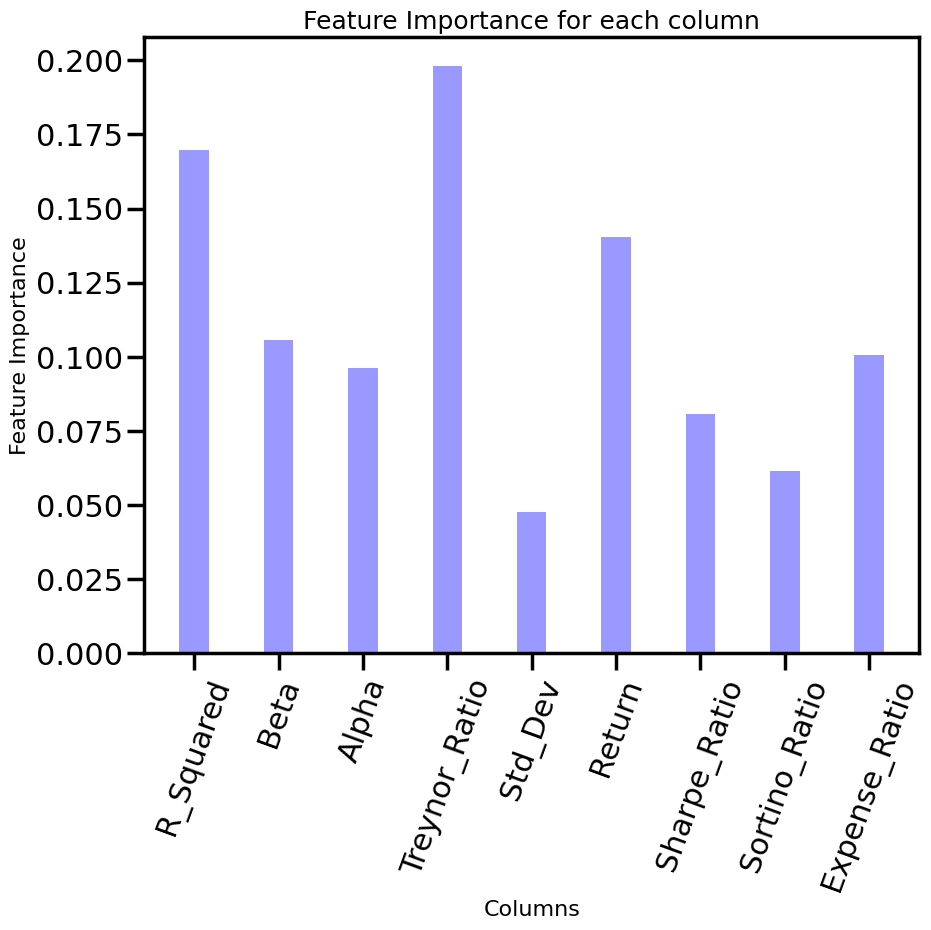

In [227]:
# Show a bar plot of feature imp of named features
index = np.arange(len(columns))
bar_width = 0.35
opacity = 0.4

plt.figure(figsize=(10,8))
plt.bar(index, feature_imp, bar_width,
                 alpha=opacity,
                 color='b',
                 label='')

plt.xlabel('Columns', fontsize =16)
plt.ylabel('Feature Importance', fontsize =16)
plt.title('Feature Importance for each column', fontsize =18)
plt.xticks(index, columns,rotation = 70)
plt.show()

Based on the above result I can sa that R squared, Treynorratio, return, Standard deviation and  sharpe ratio are the important fearures when determining the good mutual fund for 10 year investment.

Now predict the top performing funds for 10 year investment based on the model fitted above.

In [228]:
Y_predict = clf.predict(X) # predict the result
fund_data['Predicted_result'] = Y_predict

#sort top fund in descending order of return
good_fund_ten_yrs = fund_data.query("Predicted_result==1").sort_values(['Net_returns'],ascending=False).reset_index(drop=True)

Show top performing funds for 10 year investment.

In [229]:
good_fund_ten_yrs #show top perfoming fund

Fund_Ticker          Benchmark_Index  R_Squared  Beta  Alpha  \
0        PRMTX         MSCI ACWI NR USD      84.94  1.06   7.84   
1        FBSOX         MSCI ACWI NR USD      73.98  0.96   6.57   
2        FKSCX  MSCI ACWI Ex USA NR USD      83.96  0.85   6.63   
3        FBMPX         MSCI ACWI NR USD      78.81  1.03   4.60   
4        FSDAX         MSCI ACWI NR USD      70.98  0.94   4.75   
5        VPMCX           S&P 500 TR USD      83.87  0.94   3.93   
6        SMGIX           S&P 500 TR USD      96.37  1.05   0.32   
7        SLMCX         MSCI ACWI NR USD      70.85  0.90   4.93   
8        PSPTX           S&P 500 TR USD      92.11  1.05   2.54   
9        ANEFX           S&P 500 TR USD      77.70  1.07   0.73   
10       VASVX           S&P 500 TR USD      83.52  0.98   0.02   
11       FSMVX           S&P 500 TR USD      87.41  1.10   1.13   
12       FLMVX           S&P 500 TR USD      86.39  0.90   2.99   
13       VDIGX           S&P 500 TR USD      91.58  0.87   0.30   

    Treynor_Ratio Currency  Year_Trailing  Std_Dev  Return  Sharpe_Ratio  \
0           12.93      USD             10    19.09   15.27          0.77   
1           12.24      USD             10    18.34   13.23          0.69   
2           12.82      USD             10    17.48   12.44          0.68   
3            9.62      USD             10    19.08   11.41          0.58   
4           10.12      USD             10    18.49   11.06          0.58   
5           25.73      USD             10    15.18   10.55          0.64   
6           21.28      USD             10    15.30   10.72          0.64   
7           10.72      USD             10    17.64   11.15          0.60   
8           23.83      USD             10    17.21   10.20          0.56   
9           21.64      USD             10    16.37    9.79          0.56   
10          20.76      USD             10    15.73    9.57          0.56   
11          22.18      USD             10    18.28    9.88          0.53   
12          24.61      USD             10    15.23   10.13          0.61   
13          21.04      USD             10    12.02    9.48          0.69   

    Sortino_Ratio  Expense_Ratio  Net_returns  Predicted_result  
0            1.14          1.127       14.143                 1  
1            1.04          1.012       12.218                 1  
2            1.02          0.983       11.457                 1  
3            0.89          0.975       10.435                 1  
4            0.82          0.894       10.166                 1  
5            0.95          0.450       10.100                 1  
6            0.96          0.903        9.817                 1  
7            0.91          1.444        9.706                 1  
8            0.81          0.670        9.530                 1  
9            0.82          0.286        9.504                 1  
10           0.82          0.112        9.458                 1  
11           0.75          0.491        9.389                 1  
12           0.87          0.745        9.385                 1  
13           1.00          0.342        9.138                 1

First I'll see he relationship between expense ratio and Returns using scatter plot for top performing funds.

Text(0, 0.5, 'Expense Ratio')

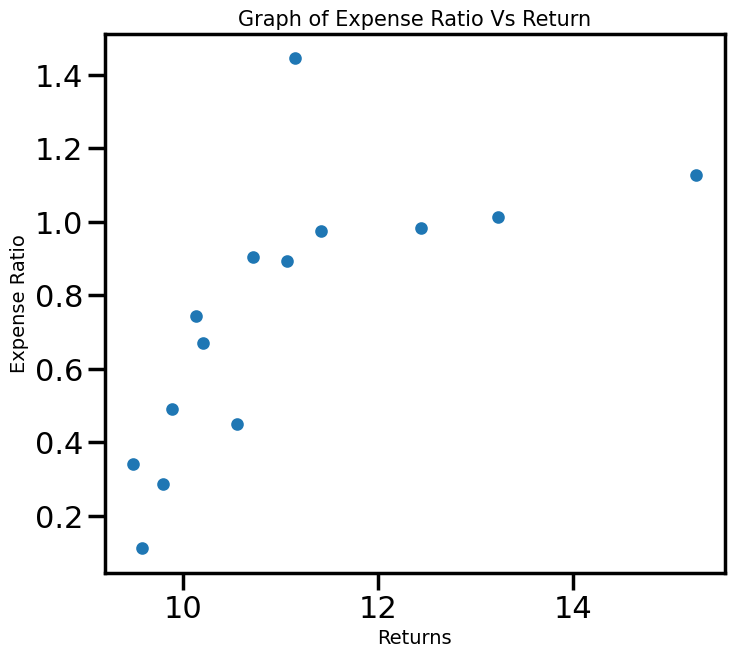

In [230]:
#Plot Returns  Vs Expense ratio
plt.figure(figsize=(8,7))
x=good_fund_ten_yrs.Return
y=good_fund_ten_yrs.Expense_Ratio
plt.scatter(x,y,s=50)
plt.title("Graph of Expense Ratio Vs Return", fontsize=15)
plt.xlabel("Returns" , fontsize=14)
plt.ylabel("Expense Ratio", fontsize=14)

Based on the above graph I can say that fund having more expense ratio give better returns in case of 10 year investment unlike 3. 5 year investments.

Text(0.5, 1.0, 'Graph of Net Returns Vs Risk for 10 Years')

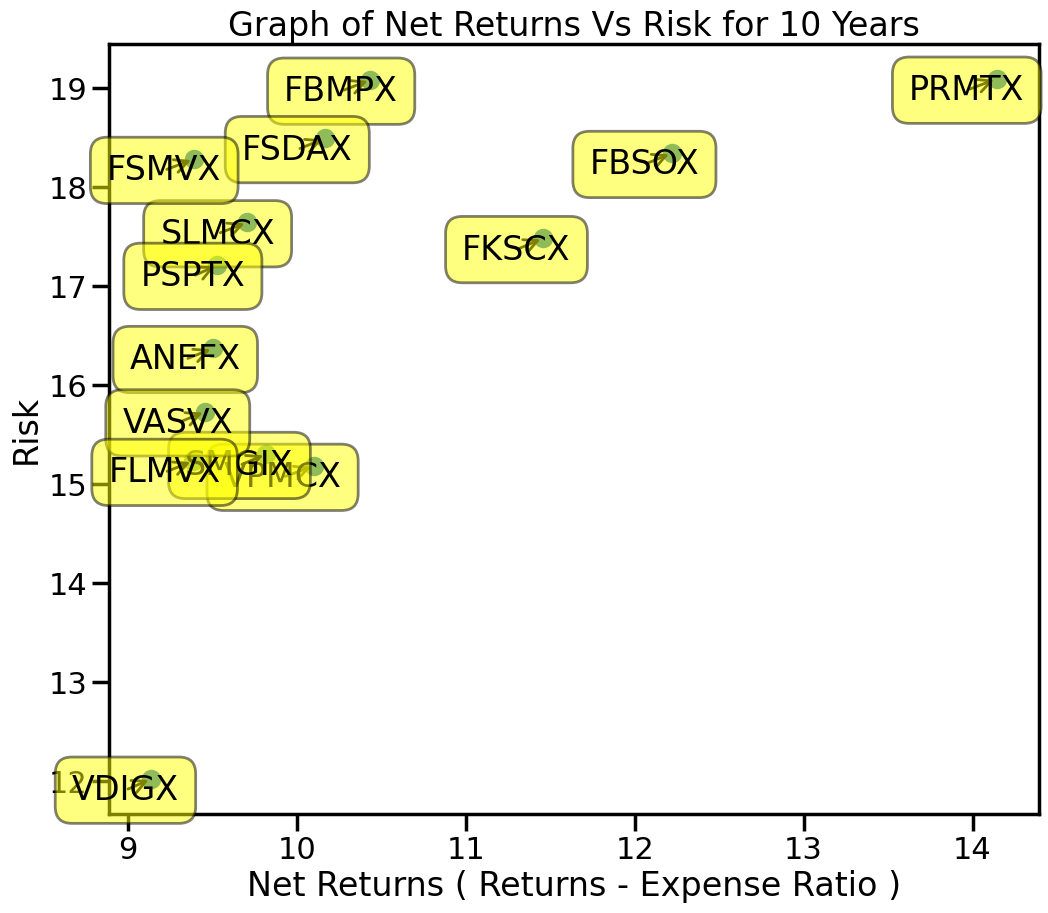

In [231]:
# plot a graph of Returns Vs Standard deviation
plot_returns_Vs_risk(good_fund_ten_yrs)
plt.title("Graph of Net Returns Vs Risk for 10 Years")


#### 1.3.1 More insight into good Funds for 10 years investment

Now I will pick 5 funds from the good funds which I culated above and see how these funds are behaving this year. I gather data from yahoo finance for daily returns.
I will consider the following good funds: 'SLMCX','FBMPX','VPMCX','FBSOX','PRMTX'

In [232]:
import datetime

tickers = ['PIXAX', 'PSTKX', 'FLMVX', 'VIVAX', 'VPCCX']
print("Method 1: Handling MultiIndex structure")
try:
    raw_data = yf.download(tickers, 
                           start=datetime.datetime(2014, 1, 1), 
                           end=datetime.datetime(2014, 12, 31))
    
    print("Raw data columns:", raw_data.columns.names)
    print("Column levels:", raw_data.columns.nlevels)
    
    # Extract Adj Close for multiple tickers
    if raw_data.columns.nlevels > 1:
        data = raw_data['Adj Close']
    else:
        data = raw_data
        
    print("Extracted data shape:", data.shape)
    print("Data columns:", data.columns.tolist())
    
except Exception as e:
    print(f"Method 1 failed: {e}")


/tmp/ipykernel_24038/662925995.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers,
[*********************100%***********************]  5 of 5 completed

Method 1: Handling MultiIndex structure
Raw data columns: ['Price', 'Ticker']
Column levels: 2
Method 1 failed: 'Adj Close'


Find correlation between the selected funds and plot heat map showing correlation

In [233]:
corr = data.corr()
corr

Price             Close                                              High  \
Ticker            FAVAX     PIXAX     PSPTX     PSTKX     VQNPX     FAVAX   
Price  Ticker                                                               
Close  FAVAX   1.000000  0.792592  0.984639  0.985656  0.981790  1.000000   
       PIXAX   0.792592  1.000000  0.772489  0.787063  0.803728  0.792592   
       PSPTX   0.984639  0.772489  1.000000  0.999120  0.997000  0.984639   
       PSTKX   0.985656  0.787063  0.999120  1.000000  0.998397  0.985656   
       VQNPX   0.981790  0.803728  0.997000  0.998397  1.000000  0.981790   
High   FAVAX   1.000000  0.792592  0.984639  0.985656  0.981790  1.000000   
       PIXAX   0.792592  1.000000  0.772489  0.787063  0.803728  0.792592   
       PSPTX   0.984639  0.772489  1.000000  0.999120  0.997000  0.984639   
       PSTKX   0.985656  0.787063  0.999120  1.000000  0.998397  0.985656   
       VQNPX   0.981790  0.803728  0.997000  0.998397  1.000000  0.981790   
Low    FAVAX   1.000000  0.792592  0.984639  0.985656  0.981790  1.000000   
       PIXAX   0.792592  1.000000  0.772489  0.787063  0.803728  0.792592   
       PSPTX   0.984639  0.772489  1.000000  0.999120  0.997000  0.984639   
       PSTKX   0.985656  0.787063  0.999120  1.000000  0.998397  0.985656   
       VQNPX   0.981790  0.803728  0.997000  0.998397  1.000000  0.981790   
Open   FAVAX   1.000000  0.792592  0.984639  0.985656  0.981790  1.000000   
       PIXAX   0.792592  1.000000  0.772489  0.787063  0.803728  0.792592   
       PSPTX   0.984639  0.772489  1.000000  0.999120  0.997000  0.984639   
       PSTKX   0.985656  0.787063  0.999120  1.000000  0.998397  0.985656   
       VQNPX   0.981790  0.803728  0.997000  0.998397  1.000000  0.981790   
Volume FAVAX        NaN       NaN       NaN       NaN       NaN       NaN   
       PIXAX        NaN       NaN       NaN       NaN       NaN       NaN   
       PSPTX        NaN       NaN       NaN       NaN       NaN       NaN   
       PSTKX        NaN       NaN       NaN       NaN       NaN       NaN   
       VQNPX        NaN       NaN       NaN       NaN       NaN       NaN   

Price                                                  ...      Open  \
Ticker            PIXAX     PSPTX     PSTKX     VQNPX  ...     FAVAX   
Price  Ticker                                          ...             
Close  FAVAX   0.792592  0.984639  0.985656  0.981790  ...  1.000000   
       PIXAX   1.000000  0.772489  0.787063  0.803728  ...  0.792592   
       PSPTX   0.772489  1.000000  0.999120  0.997000  ...  0.984639   
       PSTKX   0.787063  0.999120  1.000000  0.998397  ...  0.985656   
       VQNPX   0.803728  0.997000  0.998397  1.000000  ...  0.981790   
High   FAVAX   0.792592  0.984639  0.985656  0.981790  ...  1.000000   
       PIXAX   1.000000  0.772489  0.787063  0.803728  ...  0.792592   
       PSPTX   0.772489  1.000000  0.999120  0.997000  ...  0.984639   
       PSTKX   0.787063  0.999120  1.000000  0.998397  ...  0.985656   
       VQNPX   0.803728  0.997000  0.998397  1.000000  ...  0.981790   
Low    FAVAX   0.792592  0.984639  0.985656  0.981790  ...  1.000000   
       PIXAX   1.000000  0.772489  0.787063  0.803728  ...  0.792592   
       PSPTX   0.772489  1.000000  0.999120  0.997000  ...  0.984639   
       PSTKX   0.787063  0.999120  1.000000  0.998397  ...  0.985656   
       VQNPX   0.803728  0.997000  0.998397  1.000000  ...  0.981790   
Open   FAVAX   0.792592  0.984639  0.985656  0.981790  ...  1.000000   
       PIXAX   1.000000  0.772489  0.787063  0.803728  ...  0.792592   
       PSPTX   0.772489  1.000000  0.999120  0.997000  ...  0.984639   
       PSTKX   0.787063  0.999120  1.000000  0.998397  ...  0.985656   
       VQNPX   0.803728  0.997000  0.998397  1.000000  ...  0.981790   
Volume FAVAX        NaN       NaN       NaN       NaN  ...       NaN   
       PIXAX        NaN       NaN       NaN       NaN  ...       NaN   
       PSPTX        NaN       NaN       NaN

Text(0.5, 1.0, 'Correlation between Funds')

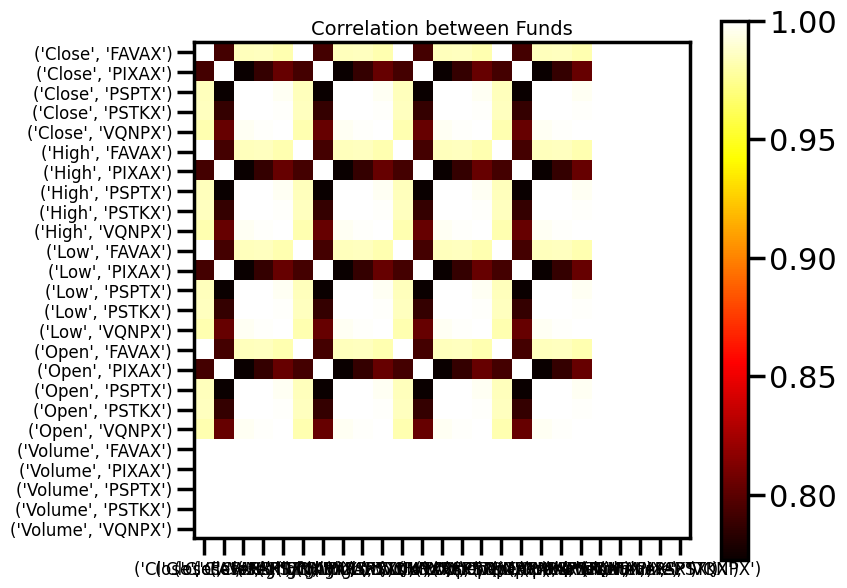

In [234]:
#Plot heat map for correlation
plt.figure(figsize=(8,7))
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, fontsize = 12)
plt.yticks(range(len(corr)), corr.columns, fontsize = 12);
plt.title("Correlation between Funds",fontsize=14)

Show histogram of selected funds

array([[<Axes: title={'center': "('Close', 'FAVAX')"}>,
        <Axes: title={'center': "('Close', 'PIXAX')"}>,
        <Axes: title={'center': "('Close', 'PSPTX')"}>,
        <Axes: title={'center': "('Close', 'PSTKX')"}>,
        <Axes: title={'center': "('Close', 'VQNPX')"}>],
       [<Axes: title={'center': "('High', 'FAVAX')"}>,
        <Axes: title={'center': "('High', 'PIXAX')"}>,
        <Axes: title={'center': "('High', 'PSPTX')"}>,
        <Axes: title={'center': "('High', 'PSTKX')"}>,
        <Axes: title={'center': "('High', 'VQNPX')"}>],
       [<Axes: title={'center': "('Low', 'FAVAX')"}>,
        <Axes: title={'center': "('Low', 'PIXAX')"}>,
        <Axes: title={'center': "('Low', 'PSPTX')"}>,
        <Axes: title={'center': "('Low', 'PSTKX')"}>,
        <Axes: title={'center': "('Low', 'VQNPX')"}>],
       [<Axes: title={'center': "('Open', 'FAVAX')"}>,
        <Axes: title={'center': "('Open', 'PIXAX')"}>,
        <Axes: title={'center': "('Open', 'PSPTX')"}>,
       

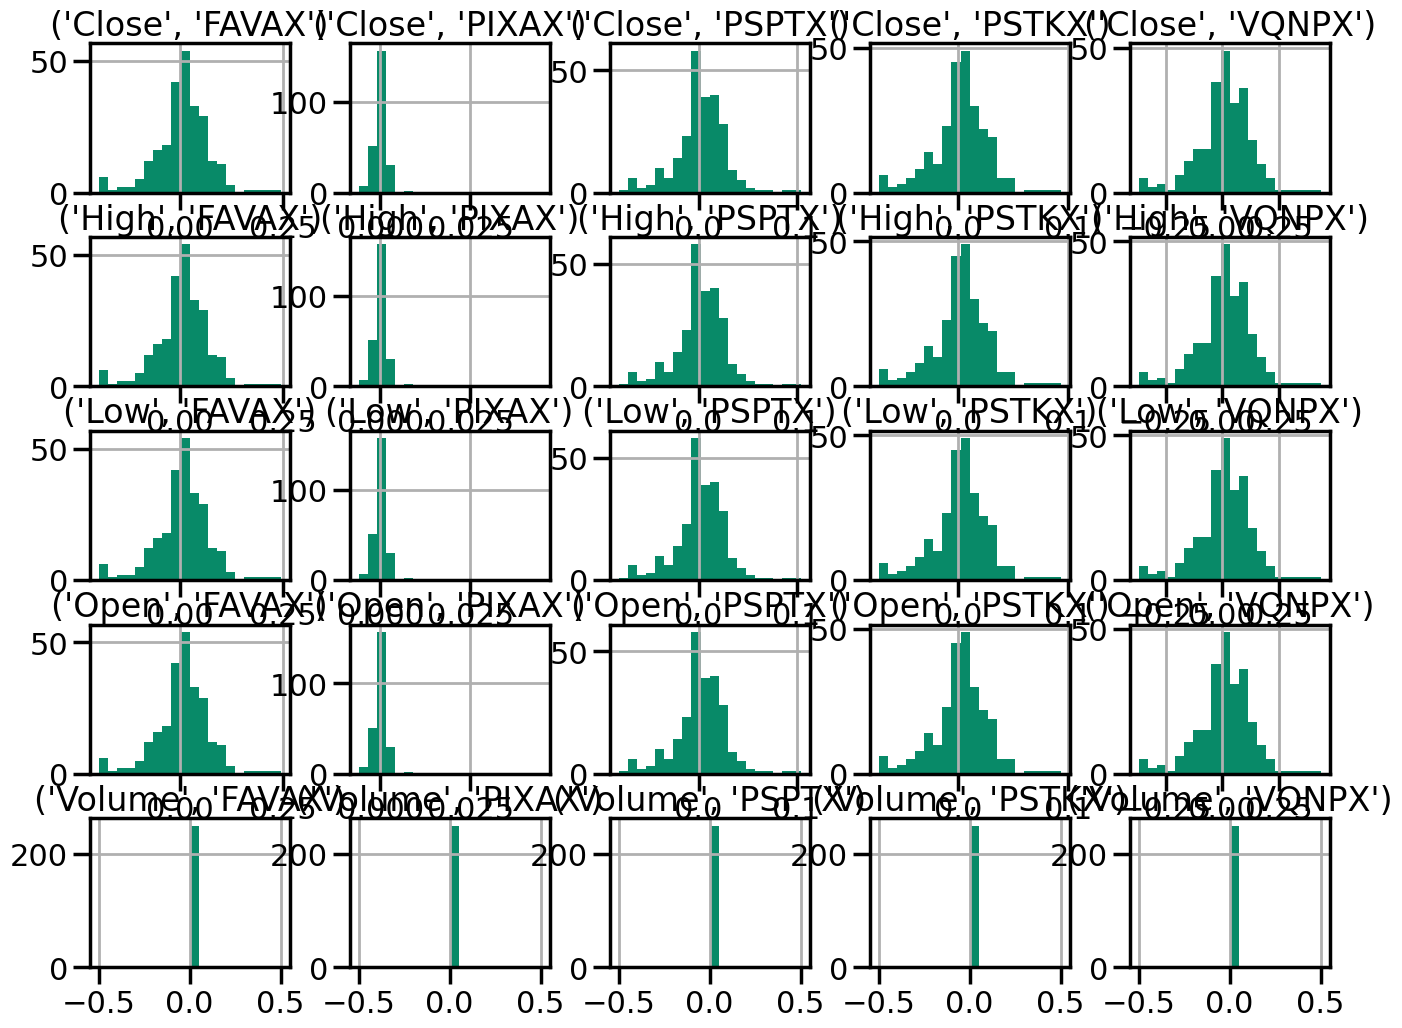

In [235]:
data.diff().hist(figsize=(16,12),bins=20,color="#088A68")

Show Percentage returns for each fund for year

(array([   0., 1000., 2000., 3000., 4000., 5000.]),
 [Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000')])

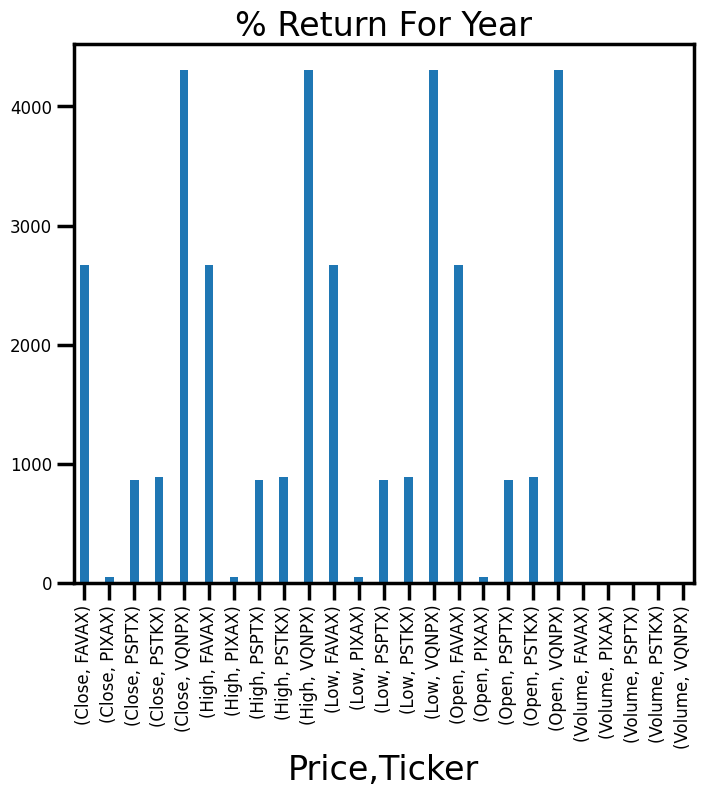

In [236]:

plt.figure(figsize=(8,7))
data.sum().plot(kind='bar',title="% Return For Year", width=0.35)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

Plot chart of cumulative sum of selcted funds.

Text(0.5, 1.0, ' Cumulative sum of Selected Funds')

<Figure size 640x480 with 0 Axes>

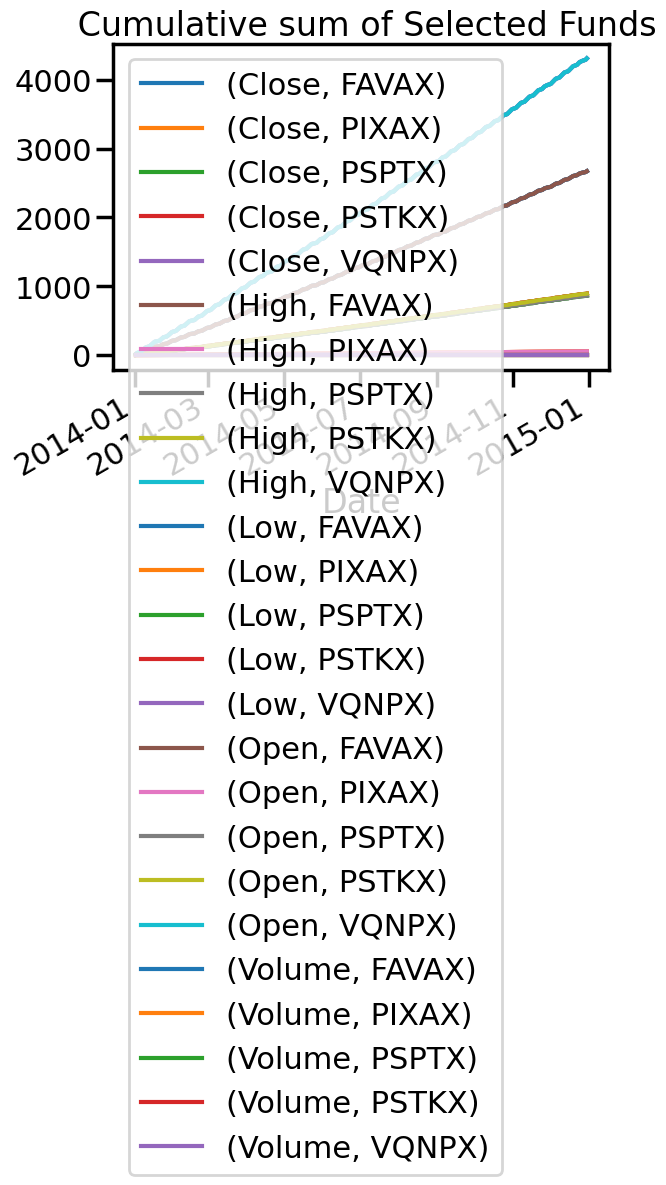

In [237]:
ts = data.cumsum()
plt.figure(); ts.plot(); plt.legend(loc='upper left')
plt.title(" Cumulative sum of Selected Funds")

Based on the above analysis I can say that SLMCX is performing better than rest of the top perfoming funds for 10 years.

###Summary for 10 year investments

I used Random Foreset classifer to predict top performing funds for 10 year investment. I used cross validtaion to find the best value for n_estimator and predicted top 20 funds for investment.
Based on our analysis FSDAX,FBMPX,FKSCX,FBSOX,PRMTX are one of the top performing funds for 10 year investments which give more than 9% returns with less tha 20% risk.

Also fund with more expense ratio give more returns for 10 years investment unlike 3 and 5 years investment.

## 2. Predict Poor Performing funds

One should not invest in a fund which is consistantly giving bad returns over years.
I gathered past 10 years data from morningstar website and build a regression model to predict a fund which has poor performance.


### 2.1 Build Regression Model Based on Fund Returns data


Gather past 10 years fund returns for each fund and build a data frame containing past 10 years record for each fund as training set and current year data as test set.

In [ ]:
# Clean implementation of regression model
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def prepare_fund_data(fund_meta_data, fund_returns):
    """
    Prepare training and test data for all funds
    """
    X_train_all = pd.DataFrame()
    Y_train_all = pd.DataFrame()
    X_test_all = pd.DataFrame()
    Y_test_all = pd.DataFrame()
    ticker_arr = []
    
    for ticker in fund_meta_data.Fund_Ticker:
        try:
            # Get fund history
            fund_history = fund_returns[ticker].copy()
            
            # Extract features (X) and target (Y)
            X = fund_history.drop(fund_history.columns[[0,1,8]], axis=1)
            Y = fund_history.iloc[:, [1]]  # Second column
            
            # Convert to numeric, coercing errors to NaN
            X = X.apply(pd.to_numeric, errors='coerce')
            Y = Y.apply(pd.to_numeric, errors='coerce')
            
            # Remove rows with any NaN values
            valid_mask = ~(X.isnull().any(axis=1) | Y.isnull().any(axis=1))
            X = X[valid_mask]
            Y = Y[valid_mask]
            
            # Skip if insufficient data
            if len(X) < 2:
                continue
                
            # Set column names
            X.columns = ['Risk', 'Category', '+/- S&P', '+/- Category', 
                        'Annual_Net_Exp_Ratio', 'Turnover_Ratio']
            Y.columns = ['Returns']
            
            # Split into train/test
            X_train = X[:-1]  # All but last row
            Y_train = Y[:-1]  # All but last row
            X_test = X[-1:]   # Last row only
            Y_test = Y[-1:]   # Last row only
            
            # Skip if empty training data
            if len(X_train) == 0:
                continue
                
            # Append to combined datasets
            X_train_all = pd.concat([X_train_all, X_train], ignore_index=True)
            Y_train_all = pd.concat([Y_train_all, Y_train], ignore_index=True)
            X_test_all = pd.concat([X_test_all, X_test], ignore_index=True)
            Y_test_all = pd.concat([Y_test_all, Y_test], ignore_index=True)
            
            ticker_arr.append(ticker)
            
        except Exception as e:
            # Skip funds with data issues
            print(f"Skipping {ticker}: {str(e)}")
            continue
    
    return X_train_all, Y_train_all, X_test_all, Y_test_all, ticker_arr

def fit_and_predict(X_train, Y_train, X_test, Y_test, ticker_arr):
    """
    Fit regression model and make predictions
    """
    # Final data cleaning
    train_mask = (~X_train.isnull().any(axis=1) & 
                  ~Y_train.isnull().any(axis=1) &
                  ~np.isinf(X_train).any(axis=1) &
                  ~np.isinf(Y_train).any(axis=1))
    
    X_train_clean = X_train[train_mask]
    Y_train_clean = Y_train[train_mask]
    
    if len(X_train_clean) == 0:
        raise ValueError("No valid training data after cleaning")
    
    # Fit the model
    clf = linear_model.LinearRegression()
    clf.fit(X_train_clean, Y_train_clean)
    
    # Clean test data
    test_mask = (~X_test.isnull().any(axis=1) & 
                 ~np.isinf(X_test).any(axis=1))
    
    X_test_clean = X_test[test_mask]
    Y_test_clean = Y_test[test_mask]
    
    # Make predictions
    predictions = clf.predict(X_test_clean)
    
    # Create results dataframe
    result = pd.DataFrame({
        'Fund_Ticker': [ticker_arr[i] for i in range(len(ticker_arr)) if test_mask.iloc[i]],
        'Actual_returns': Y_test_clean['Returns'].values,
        'Predicted_returns': predictions.flatten()
    })
    
    return clf, result

# Usage:
try:
    # Prepare data
    X_train_all, Y_train_all, X_test_all, Y_test_all, ticker_arr = prepare_fund_data(
        fund_meta_data, fund_returns
    )
    
    print(f"Training data shape: {X_train_all.shape}")
    print(f"Test data shape: {X_test_all.shape}")
    print(f"Number of funds processed: {len(ticker_arr)}")
    
    # Fit model and predict
    model, results = fit_and_predict(
        X_train_all, Y_train_all, X_test_all, Y_test_all, ticker_arr
    )
    
    print(f"\nModel coefficients: {model.coef_}")
    print(f"Model intercept: {model.intercept_}")
    print(f"\nResults shape: {results.shape}")
    print(f"First 10 results:\n{results.head(10)}")
    
    # Calculate some basic metrics if I have predictions
    if len(results) > 0:
        mse = mean_squared_error(results['Actual_returns'], results['Predicted_returns'])
        r2 = r2_score(results['Actual_returns'], results['Predicted_returns'])
        print(f"\nModel Performance:")
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"R² Score: {r2:.4f}")
        
except Exception as e:
    print(f"Error: {str(e)}")
    print("Please check your data and try the debugging code first")

Skipping PQTAX: index 0 is out of bounds for axis 0 with size 0
Skipping OMEAX: index 0 is out of bounds for axis 0 with size 0
Skipping FASPX: index 0 is out of bounds for axis 0 with size 0
Skipping FSMVX: index 0 is out of bounds for axis 0 with size 0
Skipping LIQIX: index 0 is out of bounds for axis 0 with size 0
Skipping MBGRX: index 0 is out of bounds for axis 0 with size 0
Skipping RRIAX: index 0 is out of bounds for axis 0 with size 0
Training data shape: (12826, 6)
Test data shape: (1224, 6)
Number of funds processed: 1224

Model coefficients: [[ 4.63080139e-01  5.36927094e-01  4.63072093e-01  5.36926090e-01
  -3.11146742e-05 -3.08053585e-07]]
Model intercept: [0.00035376]

Results shape: (1224, 3)
First 10 results:
  Fund_Ticker  Actual_returns  Predicted_returns
0       VFINX           13.81          13.810373
1       VBINX            9.83           9.830299
2       VCAIX            7.46           7.460372
3       VCITX           11.00          11.000420
4       VHCOX      

Build a regression model based on past 10 years data and predict returns for each fund

In [241]:
# Fit a regression model for training data
clf = linear_model.LinearRegression()
clf.fit(X_train_all,Y_train_all)
 
result = pd.DataFrame()
result['Fund_Ticker'] = ticker_arr
result['Actual_returns'] = Y_test_all.reset_index(drop=1)

 Predict poor performing funds

In [242]:
result['Predicted_returns'] = clf.predict(X_test_all)

Get the funds having negative predicted returns from the result data frame. I will consider these are the bad funds which one should avoid.


In [246]:
bad_funds = result.query('Predicted_returns<0').sort_values(['Predicted_returns'],ascending=True).reset_index(drop=1)


In [247]:
# SHow bad funds 
bad_funds[:10]

Fund_Ticker  Actual_returns  Predicted_returns
0       TREMX          -22.92         -22.919030
1       SSGRX          -22.39         -22.394993
2       FSESX          -19.02         -19.024976
3       OPGSX          -17.21         -17.209639
4       FRNRX          -17.16         -17.164981
5       JGNAX          -16.72         -16.719376
6       PCLAX          -16.04         -16.039822
7       QRAAX          -14.43         -14.429670
8       CCIYX          -13.34         -13.339781
9       FAGNX          -12.27         -12.275029

Find total number of bad funds in given data

In [248]:
len(bad_funds)

155

There are 155 funds in the data which have poor performance. It is advisable not to invest in these funds.
Show bar plot of Returns for few bad funds from the predicted data

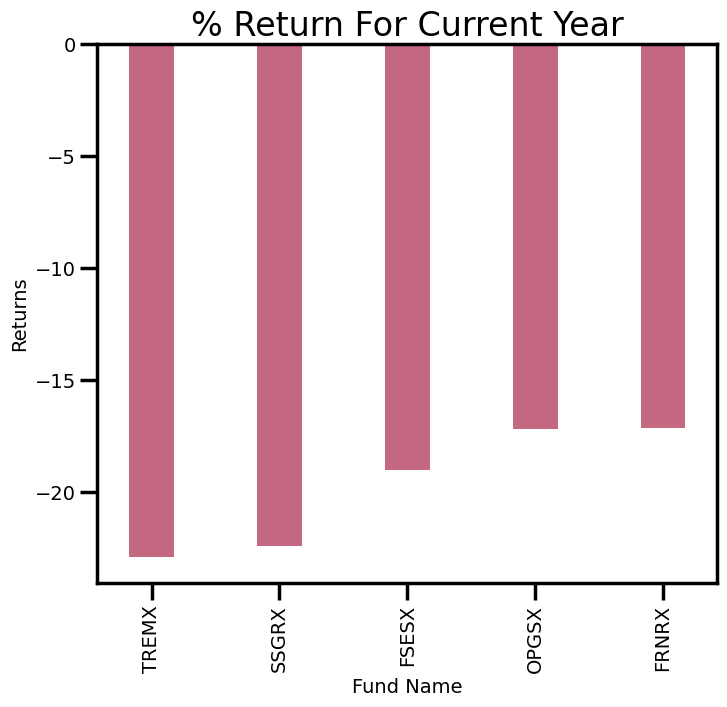

In [249]:
plt.figure(figsize=(8,7))
columns=bad_funds.Fund_Ticker[:5]
index = np.arange(len(columns))
 
bad_funds[:5].Predicted_returns.plot(kind='bar',title="% Return For Current Year",label='', width=0.35,color="#C56983")
plt.xticks(index, columns,rotation = 70,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Fund Name', fontsize =14)
plt.ylabel('Returns', fontsize =14)
plt.xticks(index, columns,rotation = 90)
plt.show()

I will select any 5 poor performing funds from the above result and show their daily returns for current year. I will select TREMX , SSGRX , FSESX,OPGSX , FRNRX

In [251]:
tickers = ['TREMX','SSGRX','FSESX','OPGSX','FRNRX']
try:
    raw_data = yf.download(tickers, 
                           start=datetime.datetime(2014, 1, 1), 
                           end=datetime.datetime(2014, 12, 31))
    
    print("Raw data columns:", raw_data.columns.names)
    print("Column levels:", raw_data.columns.nlevels)
    
    # Extract Adj Close for multiple tickers
    if raw_data.columns.nlevels > 1:
        data = raw_data['Adj Close']
    else:
        data = raw_data
        
    print("Extracted data shape:", data.shape)
    print("Data columns:", data.columns.tolist())
    
except Exception as e:
    print(f"Method 1 failed: {e}")


/tmp/ipykernel_24038/3379974468.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers,
[*********************100%***********************]  5 of 5 completed

Raw data columns: ['Price', 'Ticker']
Column levels: 2
Method 1 failed: 'Adj Close'


Text(0.5, 1.0, ' Cumulative sum of selected bad funds')

<Figure size 640x480 with 0 Axes>

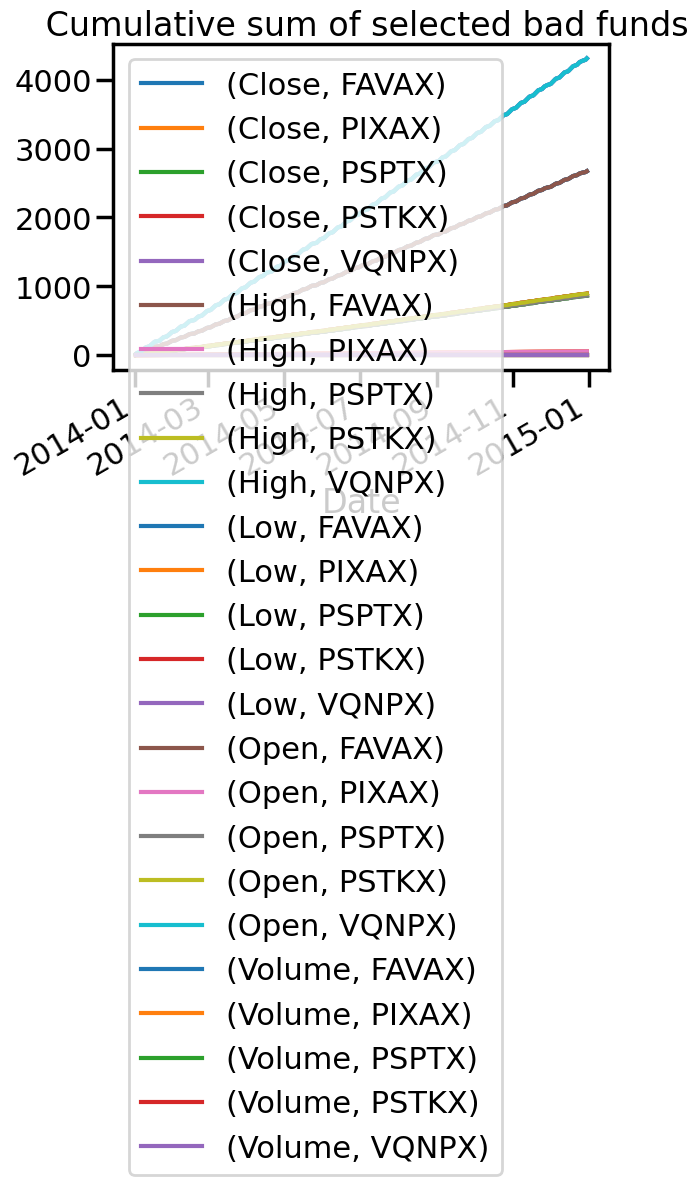

In [252]:
#Plot chart of cumsum
ts = data.cumsum()
plt.figure(); ts.plot(); plt.legend(loc='upper left')
plt.title(" Cumulative sum of selected bad funds")

##Summary of poor performing Funds

I have predicted poor performing funds using regression of past 10 years data. Also it can be seen from above plot these funds are preforming poor day by day. It is advisable not to invest in these funds.
